In [876]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score  # For cross-validation
from sklearn import metrics  # For model evaluation (accuracy, AUC score)
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from glicko2 import Player
import xgboost as xgb


In [877]:
def process_season(df):
    
    # List of teams
    teams = set(df['HomeTeam']).union(set(df['AwayTeam']))
    
    # Initialize dictionaries to store team statistics
    team_stats = {team: {
        'home_games': 0,
        'away_games': 0,
        'home_goals': 0,
        'away_goals': 0,
        'home_corners': 0,
        'away_corners': 0,
        'home_fouls': 0,
        'away_fouls': 0,
        'home_yellow_cards': 0,
        'away_yellow_cards': 0,
        'home_shots': 0,
        'away_shots': 0,
        'home_shots_target': 0,
        'away_shots_target': 0,
        'goals_for': 0, 
        'goals_against': 0 
    } for team in teams}
  
    # Function to calculate and store team stats
    def calculate_team_stats(team, is_home, row_idx):
        stats = team_stats[team]
        prefix = 'Home' if is_home else 'Away'
        
        # Store current stats (before the match)
        df.at[row_idx, f'{prefix}Team_home_games'] = stats['home_games']
        df.at[row_idx, f'{prefix}Team_away_games'] = stats['away_games']
        df.at[row_idx, f'{prefix}Team_goals_for'] = stats['goals_for']  # New
        df.at[row_idx, f'{prefix}Team_goals_against'] = stats['goals_against']  # New
        
# Calculate and store averages
        for stat in ['goals', 'corners', 'fouls', 'yellow_cards', 'shots', 'shots_target']:
            for location in ['home', 'away']:
                games = stats[f'{location}_games']
                avg = float(stats[f'{location}_{stat}']) / games if games > 0 else 0.0  # Ensure default is 0.0
                df.at[row_idx, f'{prefix}Team_avg_{location}_{stat}'] = avg

        
        # Update stats after storing (for the next match)
        if is_home:
            stats['home_games'] += 1
            goals_scored = df.at[row_idx, 'FTHG']
            goals_conceded = df.at[row_idx, 'FTAG']
            stats['home_goals'] += goals_scored
            stats['home_corners'] += df.at[row_idx, 'HC']
            stats['home_fouls'] += df.at[row_idx, 'HF']
            stats['home_yellow_cards'] += df.at[row_idx, 'HY']
            stats['home_shots'] += df.at[row_idx, 'HS']
            stats['home_shots_target'] += df.at[row_idx, 'HST']
        else:
            stats['away_games'] += 1
            goals_scored = df.at[row_idx, 'FTAG']
            goals_conceded = df.at[row_idx, 'FTHG']
            stats['away_goals'] += goals_scored
            stats['away_corners'] += df.at[row_idx, 'AC']
            stats['away_fouls'] += df.at[row_idx, 'AF']
            stats['away_yellow_cards'] += df.at[row_idx, 'AY']
            stats['away_shots'] += df.at[row_idx, 'AS']
            stats['away_shots_target'] += df.at[row_idx, 'AST']
        
        # Update goals for and against
        stats['goals_for'] += goals_scored
        stats['goals_against'] += goals_conceded
    
    # Calculate rolling stats for each team with offset
    for idx, row in df.iterrows():
        calculate_team_stats(row['HomeTeam'], True, idx)
        calculate_team_stats(row['AwayTeam'], False, idx)
        
    
    # Calculate points
    df['HomePoints'] = df['FTR'].map({'H': 3, 'D': 1, 'A': 0})
    df['AwayPoints'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 3})
    
    # Calculate cumulative points and positions
    points = {team: 0 for team in teams}
    positions = {team: 1 for team in teams}
    
    for idx, row in df.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        
        # Store current points and positions (before the match)
        df.at[idx, 'HomeTeamCumulativePoints'] = points[home_team]
        df.at[idx, 'AwayTeamCumulativePoints'] = points[away_team]
        df.at[idx, 'HomeTeamPosition'] = positions[home_team]
        df.at[idx, 'AwayTeamPosition'] = positions[away_team]
        
        # Update points after storing (for the next match)
        points[home_team] += row['HomePoints']
        points[away_team] += row['AwayPoints']
        
        # Recalculate positions for the next match
        sorted_teams = sorted(points.items(), key=lambda x: (-x[1], x[0]))
        for rank, (team, _) in enumerate(sorted_teams, 1):
            positions[team] = rank
    
    return df


In [878]:
import pandas as pd

# Step 1: Load your CSV files
# Premier League
df_19_20_prem = pd.read_csv('./data/prem/19-20.csv')
df_20_21_prem = pd.read_csv('./data/prem/20-21.csv')
df_21_22_prem = pd.read_csv('./data/prem/21-22.csv')
df_22_23_prem = pd.read_csv('./data/prem/22-23.csv')
df_23_24_prem = pd.read_csv('./data/prem/23-24.csv')
df_24_25_prem = pd.read_csv('./data/prem/24-25.csv')

# Serie A
df_19_20_seriea = pd.read_csv('./data/seriea/19-20.csv')
df_20_21_seriea = pd.read_csv('./data/seriea/20-21.csv')
df_21_22_seriea = pd.read_csv('./data/seriea/21-22.csv')
df_22_23_seriea = pd.read_csv('./data/seriea/22-23.csv')
df_23_24_seriea = pd.read_csv('./data/seriea/23-24.csv')
df_24_25_seriea = pd.read_csv('./data/seriea/24-25.csv')

# La Liga
df_19_20_laliga = pd.read_csv('./data/laliga/19-20.csv')
df_20_21_laliga = pd.read_csv('./data/laliga/20-21.csv')
df_21_22_laliga = pd.read_csv('./data/laliga/21-22.csv')
df_22_23_laliga = pd.read_csv('./data/laliga/22-23.csv')
df_23_24_laliga = pd.read_csv('./data/laliga/23-24.csv')
df_24_25_laliga = pd.read_csv('./data/laliga/24-25.csv')

# Ligue 1 (France)
df_19_20_france = pd.read_csv('./data/france/19-20.csv')
df_20_21_france = pd.read_csv('./data/france/20-21.csv')
df_21_22_france = pd.read_csv('./data/france/21-22.csv')
df_22_23_france = pd.read_csv('./data/france/22-23.csv')
df_23_24_france = pd.read_csv('./data/france/23-24.csv')
df_24_25_france = pd.read_csv('./data/france/24-25.csv')

# Bundesliga
df_19_20_bundesliga = pd.read_csv('./data/bundesliga/19-20.csv')
df_20_21_bundesliga = pd.read_csv('./data/bundesliga/20-21.csv')
df_21_22_bundesliga = pd.read_csv('./data/bundesliga/21-22.csv')
df_22_23_bundesliga = pd.read_csv('./data/bundesliga/22-23.csv')
df_23_24_bundesliga = pd.read_csv('./data/bundesliga/23-24.csv')
df_24_25_bundesliga = pd.read_csv('./data/bundesliga/24-25.csv')

# Primeira Liga (Portugal)
df_19_20_portugal = pd.read_csv('./data/portugal/19-20.csv')
df_20_21_portugal = pd.read_csv('./data/portugal/20-21.csv')
df_21_22_portugal = pd.read_csv('./data/portugal/21-22.csv')
df_22_23_portugal = pd.read_csv('./data/portugal/22-23.csv')
df_23_24_portugal = pd.read_csv('./data/portugal/23-24.csv')
df_24_25_portugal = pd.read_csv('./data/portugal/24-25.csv')

# Step 2: Process each season separately (assuming process_season() function is defined)
# Premier League
df_19_20_processed_prem = process_season(df_19_20_prem)
df_20_21_processed_prem = process_season(df_20_21_prem)
df_21_22_processed_prem = process_season(df_21_22_prem)
df_22_23_processed_prem = process_season(df_22_23_prem)
df_23_24_processed_prem = process_season(df_23_24_prem)
df_24_25_processed_prem = process_season(df_24_25_prem)

# Serie A
df_19_20_processed_seriea = process_season(df_19_20_seriea)
df_20_21_processed_seriea = process_season(df_20_21_seriea)
df_21_22_processed_seriea = process_season(df_21_22_seriea)
df_22_23_processed_seriea = process_season(df_22_23_seriea)
df_23_24_processed_seriea = process_season(df_23_24_seriea)
df_24_25_processed_seriea = process_season(df_24_25_seriea)

# La Liga
df_19_20_processed_laliga = process_season(df_19_20_laliga)
df_20_21_processed_laliga = process_season(df_20_21_laliga)
df_21_22_processed_laliga = process_season(df_21_22_laliga)
df_22_23_processed_laliga = process_season(df_22_23_laliga)
df_23_24_processed_laliga = process_season(df_23_24_laliga)
df_24_25_processed_laliga = process_season(df_24_25_laliga)

# Ligue 1 (France)
df_19_20_processed_france = process_season(df_19_20_france)
df_20_21_processed_france = process_season(df_20_21_france)
df_21_22_processed_france = process_season(df_21_22_france)
df_22_23_processed_france = process_season(df_22_23_france)
df_23_24_processed_france = process_season(df_23_24_france)
df_24_25_processed_france = process_season(df_24_25_france)

# Bundesliga
df_19_20_processed_bundesliga = process_season(df_19_20_bundesliga)
df_20_21_processed_bundesliga = process_season(df_20_21_bundesliga)
df_21_22_processed_bundesliga = process_season(df_21_22_bundesliga)
df_22_23_processed_bundesliga = process_season(df_22_23_bundesliga)
df_23_24_processed_bundesliga = process_season(df_23_24_bundesliga)
df_24_25_processed_bundesliga = process_season(df_24_25_bundesliga)

# Primeira Liga (Portugal)
df_19_20_processed_portugal = process_season(df_19_20_portugal)
df_20_21_processed_portugal = process_season(df_20_21_portugal)
df_21_22_processed_portugal = process_season(df_21_22_portugal)
df_22_23_processed_portugal = process_season(df_22_23_portugal)
df_23_24_processed_portugal = process_season(df_23_24_portugal)
df_24_25_processed_portugal = process_season(df_24_25_portugal)

# Step 3: Concatenate all processed dataframes
df = pd.concat([
    df_19_20_processed_prem, df_20_21_processed_prem, df_21_22_processed_prem, df_22_23_processed_prem, df_23_24_processed_prem, df_24_25_processed_prem,
    df_19_20_processed_seriea, df_20_21_processed_seriea, df_21_22_processed_seriea, df_22_23_processed_seriea, df_23_24_processed_seriea, df_24_25_processed_seriea,
    df_19_20_processed_laliga, df_20_21_processed_laliga, df_21_22_processed_laliga, df_22_23_processed_laliga, df_23_24_processed_laliga, df_24_25_processed_laliga,
    df_19_20_processed_france, df_20_21_processed_france, df_21_22_processed_france, df_22_23_processed_france, df_23_24_processed_france, df_24_25_processed_france,
    df_19_20_processed_bundesliga, df_20_21_processed_bundesliga, df_21_22_processed_bundesliga, df_22_23_processed_bundesliga, df_23_24_processed_bundesliga, df_24_25_processed_bundesliga,
    df_19_20_processed_portugal, df_20_21_processed_portugal, df_21_22_processed_portugal, df_22_23_processed_portugal, df_23_24_processed_portugal, df_24_25_processed_portugal
], ignore_index=True)



In [879]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Sort the DataFrame by date
df = df.sort_values('Date').reset_index(drop=True)

In [880]:
# Initialize the tallies before the loop
total_home_wins = 0
total_away_wins = 0
total_draws = 0

for idx, row in df.iterrows():
    # Store the current tallies in the DataFrame for the previous match (shifted by 1)
    df.at[idx, 'TotalHomeWins'] = total_home_wins
    df.at[idx, 'TotalAwayWins'] = total_away_wins
    df.at[idx, 'TotalDraws'] = total_draws

    # Now update the tallies based on the current match result
    if row['FTR'] == 'H':
        total_home_wins += 1
    elif row['FTR'] == 'A':
        total_away_wins += 1
    elif row['FTR'] == 'D':
        total_draws += 1


In [881]:
df[['TotalHomeWins','TotalAwayWins','TotalDraws']].head(1600)

,TotalHomeWins,TotalAwayWins,TotalDraws
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,1.0,0.0
3,1.0,1.0,1.0
4,1.0,2.0,1.0
...,...,...,...
1595,694.0,501.0,400.0
1596,694.0,502.0,400.0
1597,695.0,502.0,400.0
1598,695.0,502.0,401.0


In [882]:
df.to_csv('all.csv',index=False)

In [883]:
# Get a list of all unique teams
teams = pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel('K'))

# Initialize streak dictionaries for each team
win_streak = {team: 0 for team in teams}
unbeaten_streak = {team: 0 for team in teams}
loss_streak = {team: 0 for team in teams}
no_win_streak = {team: 0 for team in teams}

# Lists to store the streaks for home and away teams in each match
home_win_streak = []
away_win_streak = []
home_unbeaten_streak = []
away_unbeaten_streak = []
home_loss_streak = []
away_loss_streak = []
home_no_win_streak = []
away_no_win_streak = []


# Get a list of all unique teams
teams = pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel('K'))

# Initialize streak dictionaries
win_streak = {team: 0 for team in teams}
unbeaten_streak = {team: 0 for team in teams}

# Lists to store streaks for each match
home_win_streak = []
away_win_streak = []
home_unbeaten_streak = []
away_unbeaten_streak = []

# Iterate through matches
for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    
    # Record current streaks for both teams before the match
    home_win_streak.append(win_streak[home_team])
    away_win_streak.append(win_streak[away_team])
    home_unbeaten_streak.append(unbeaten_streak[home_team])
    away_unbeaten_streak.append(unbeaten_streak[away_team])
    
    # Update streaks based on match result
    if home_goals > away_goals:
        # Home team wins
        win_streak[home_team] += 1
        unbeaten_streak[home_team] += 1
        
        # Reset away team's win streak
        win_streak[away_team] = 0
        # Update away team's unbeaten streak
        unbeaten_streak[away_team] = 0
    elif home_goals == away_goals:
        # Draw
        # Reset win streaks for both teams
        win_streak[home_team] = 0
        win_streak[away_team] = 0
        
        # Update unbeaten streaks
        unbeaten_streak[home_team] += 1
        unbeaten_streak[away_team] += 1
    else:
        # Away team wins
        win_streak[home_team] = 0
        unbeaten_streak[home_team] = 0
        
        win_streak[away_team] += 1
        unbeaten_streak[away_team] += 1

# Add streaks to DataFrame
df['HomeTeamWinStreak'] = home_win_streak
df['AwayTeamWinStreak'] = away_win_streak
df['HomeTeamUnbeatenStreak'] = home_unbeaten_streak
df['AwayTeamUnbeatenStreak'] = away_unbeaten_streak

In [962]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the 'Referee' column
df['RefereeEncoded'] = le.fit_transform(df['Referee'])

# Save the mapping for future reference (optional)
referee_mapping = dict(zip(le.classes_, le.transform(le.classes_)))


{'A Madley': 0,
 'A Marriner': 1,
 'A Moss': 2,
 'A Taylor': 3,
 'C Kavanagh': 4,
 'C Pawson': 5,
 'D Bond': 6,
 'D Coote': 7,
 'D England': 8,
 'G Scott': 9,
 'J Brooks': 10,
 'J Gillett': 11,
 'J Gillett ': 12,
 'J Moss': 13,
 'J Smith': 14,
 'K Friend': 15,
 'L Mason': 16,
 'L Smith': 17,
 'M Atkinson': 18,
 'M Dean': 19,
 'M Donohue': 20,
 'M Oliver': 21,
 'M Salisbury': 22,
 'O Langford': 23,
 'P Bankes': 24,
 'P Tierney': 25,
 'R Jones': 26,
 'R Madley': 27,
 'R Welch': 28,
 'S Allison': 29,
 'S Attwell': 30,
 'S Barrott': 31,
 'S Hooper': 32,
 'S Scott': 33,
 'S Singh': 34,
 'T Bramall': 35,
 'T Harrington': 36,
 'T Robinson': 37,
 nan: 38}

In [885]:
import pandas as pd

home_df = df[['Date', 'HomeTeam']].copy()
home_df = home_df.rename(columns={'HomeTeam': 'Team'})

# Away team data
away_df = df[['Date', 'AwayTeam']].copy()
away_df = away_df.rename(columns={'AwayTeam': 'Team'})

# Combine home and away data
team_df = pd.concat([home_df, away_df], ignore_index=True)
team_df = team_df.sort_values(['Team', 'Date'])

# Remove duplicates if a team has multiple entries on the same date
team_df = team_df.drop_duplicates(subset=['Team', 'Date'])

# Step 3: Calculate Days Since Last Match
# Get the previous match date for each team
team_df['PreviousMatchDate'] = team_df.groupby('Team')['Date'].shift()

# Calculate the difference in days
team_df['DaysSinceLastMatch'] = (team_df['Date'] - team_df['PreviousMatchDate']).dt.days

# Step 4: Merge the data back to the original DataFrame
# Merge for Home Team
home_days = team_df[['Team', 'Date', 'DaysSinceLastMatch']].rename(columns={
    'Team': 'HomeTeam',
    'DaysSinceLastMatch': 'HomeTeamDaysSinceLastMatch'
})
df = df.merge(home_days, on=['Date', 'HomeTeam'], how='left')

# Merge for Away Team
away_days = team_df[['Team', 'Date', 'DaysSinceLastMatch']].rename(columns={
    'Team': 'AwayTeam',
    'DaysSinceLastMatch': 'AwayTeamDaysSinceLastMatch'
})
df = df.merge(away_days, on=['Date', 'AwayTeam'], how='left')

In [886]:
#Replace with provided Elo ratings
elo_ratings = {
"Burnley": 1722,
    "Arsenal": 1926,
    "Bournemouth": 1660,
    "Brighton": 1843,
    "Everton": 1691,
    "Sheffield United": 1631,
    "Newcastle": 1884,
    "Brentford": 1835,
    "Chelsea": 1780,
    "Man United": 1865,
    "Nott'm Forest": 1677,
    "Fulham": 1732,
    "Liverpool": 1946,
    "Wolves": 1704,
    "Tottenham": 1829,
    "Man City": 2083,
    "Aston Villa": 1825,
    "West Ham": 1787,
    "Crystal Palace": 1758,
    "Luton": 1602,
    'Real Madrid': 1998,
    'Barcelona': 1899,
    'Ath Madrid': 1854,
    'Ath Bilbao': 1770,
    'Girona': 1766,
    'Villarreal': 1761,
    'Sociedad': 1739,
    'Betis': 1711,
    'Mallorca': 1673,
    'Osasuna': 1670,
    'Sevilla': 1670,
    'Celta': 1657,
    'Alaves': 1648,
    'Valencia': 1648,
    'Vallecano': 1635,
    'Espanol': 1600,
    'Valladolid':1577,
    'Las Palmas':1572,
    'Leganes':1569,
    'Getafe': 1629,
    'Inter': 1956,
    'Atalanta': 1853,
    'Juventus': 1843,
    'Milan': 1824,
    'Roma': 1798,
    'Napoli': 1790,
    'Lazio': 1787,
    'Bologna': 1765,
    'Fiorentina': 1747,
    'Torino': 1747,
    'Udinese': 1676,
    'Empoli': 1667,
    'Genoa': 1667,
    'Monza': 1650,
    'Verona': 1640,
    'Lecce': 1610,
    'Cagliari': 1589,
    'Parma': 1568,
    'Como': 1568,
    'Venezia': 1567,
    'Leverkusen': 1946,
    'Bayern Munich': 1927,
    'Dortmund': 1879,
    'RB Leipzig': 1852,
    'Stuttgart': 1811,
    'Ein Frankfurt': 1726,
    'Freiburg': 1691,
    'Werder Bremen': 1688,
    'Mainz': 1683,
    'Heidenheim': 1674,
    'Hoffenheim': 1662,
    'Union Berlin': 1660,
    'Wolfsburg': 1658,
    "M'gladbach": 1658,
    'Augsburg': 1616,
    'St. Pauli': 1607,
    'Bochum': 1581,
    'Holstein': 1555,
    'Paris SG': 1905,
    'Monaco': 1803,
    'Lille': 1765,
    'Marseille': 1762,
    'Lens': 1724,
    'Lyon': 1715,
    'Nice': 1707,
    'Brest': 1704,
    'Rennes': 1700,
    'Reims': 1669,
    'Strasbourg': 1640,
    'Toulouse': 1636,
    'Montpellier': 1626,
    'Nantes': 1571,
    'Auxerre': 1566,
    'Le Havre': 1553,
    'St Etienne': 1509,
    'Angers': 1473,
    'Sporting': 1851,
    'Porto': 1793,
    'Benfica': 1775,
    'Sp Braga': 1660,
    'Guimaraes': 1602,
    'Famalicao': 1516,
    'Arouca': 1495,
    'Moreirense': 1488,
    'Rio Ave': 1464,
    'Gil Vicente': 1459,
    'Casa Pia': 1445,
    'Santa Clara': 1438,
    'Estoril': 1406,
    'Boavista': 1404,
    'AVS': 1396,
    'Farense': 1394,
    'Estrela': 1390,
    'Nacional': 1390
    
}

elo_ratings_d = {
"Burnley": 1722,
    "Arsenal": 1926,
    "Bournemouth": 1660,
    "Brighton": 1843,
    "Everton": 1691,
    "Sheffield United": 1631,
    "Newcastle": 1884,
    "Brentford": 1835,
    "Chelsea": 1780,
    "Man United": 1865,
    "Nott'm Forest": 1677,
    "Fulham": 1732,
    "Liverpool": 1946,
    "Wolves": 1704,
    "Tottenham": 1829,
    "Man City": 2083,
    "Aston Villa": 1825,
    "West Ham": 1787,
    "Crystal Palace": 1758,
    "Luton": 1602,
    'Real Madrid': 1998,
    'Barcelona': 1899,
    'Ath Madrid': 1854,
    'Ath Bilbao': 1770,
    'Girona': 1766,
    'Villarreal': 1761,
    'Sociedad': 1739,
    'Betis': 1711,
    'Mallorca': 1673,
    'Osasuna': 1670,
    'Sevilla': 1670,
    'Celta': 1657,
    'Alaves': 1648,
    'Valencia': 1648,
    'Vallecano': 1635,
    'Espanol': 1600,
    'Valladolid':1577,
    'Las Palmas':1572,
    'Leganes':1569,
    'Getafe': 1629,
    'Inter': 1956,
    'Atalanta': 1853,
    'Juventus': 1843,
    'Milan': 1824,
    'Roma': 1798,
    'Napoli': 1790,
    'Lazio': 1787,
    'Bologna': 1765,
    'Fiorentina': 1747,
    'Torino': 1747,
    'Udinese': 1676,
    'Empoli': 1667,
    'Genoa': 1667,
    'Monza': 1650,
    'Verona': 1640,
    'Lecce': 1610,
    'Cagliari': 1589,
    'Parma': 1568,
    'Como': 1568,
    'Venezia': 1567,
    'Leverkusen': 1946,
    'Bayern Munich': 1927,
    'Dortmund': 1879,
    'RB Leipzig': 1852,
    'Stuttgart': 1811,
    'Ein Frankfurt': 1726,
    'Freiburg': 1691,
    'Werder Bremen': 1688,
    'Mainz': 1683,
    'Heidenheim': 1674,
    'Hoffenheim': 1662,
    'Union Berlin': 1660,
    'Wolfsburg': 1658,
    "M'gladbach": 1658,
    'Augsburg': 1616,
    'St. Pauli': 1607,
    'Bochum': 1581,
    'Holstein': 1555,
    'Paris SG': 1905,
    'Monaco': 1803,
    'Lille': 1765,
    'Marseille': 1762,
    'Lens': 1724,
    'Lyon': 1715,
    'Nice': 1707,
    'Brest': 1704,
    'Rennes': 1700,
    'Reims': 1669,
    'Strasbourg': 1640,
    'Toulouse': 1636,
    'Montpellier': 1626,
    'Nantes': 1571,
    'Auxerre': 1566,
    'Le Havre': 1553,
    'St Etienne': 1509,
    'Angers': 1473,
    'Sporting': 1851,
    'Porto': 1793,
    'Benfica': 1775,
    'Sp Braga': 1660,
    'Guimaraes': 1602,
    'Famalicao': 1516,
    'Arouca': 1495,
    'Moreirense': 1488,
    'Rio Ave': 1464,
    'Gil Vicente': 1459,
    'Casa Pia': 1445,
    'Santa Clara': 1438,
    'Estoril': 1406,
    'Boavista': 1404,
    'AVS': 1396,
    'Farense': 1394,
    'Estrela': 1390,
    'Nacional': 1390
    
}

elo_ratings_mov = {
    "Burnley": 1722,
    "Arsenal": 1926,
    "Bournemouth": 1660,
    "Brighton": 1843,
    "Everton": 1691,
    "Sheffield United": 1631,
    "Newcastle": 1884,
    "Brentford": 1835,
    "Chelsea": 1780,
    "Man United": 1865,
    "Nott'm Forest": 1677,
    "Fulham": 1732,
    "Liverpool": 1946,
    "Wolves": 1704,
    "Tottenham": 1829,
    "Man City": 2083,
    "Aston Villa": 1825,
    "West Ham": 1787,
    "Crystal Palace": 1758,
    "Luton": 1602,
    'Real Madrid': 1998,
    'Barcelona': 1899,
    'Ath Madrid': 1854,
    'Ath Bilbao': 1770,
    'Girona': 1766,
    'Villarreal': 1761,
    'Sociedad': 1739,
    'Betis': 1711,
    'Mallorca': 1673,
    'Osasuna': 1670,
    'Sevilla': 1670,
    'Celta': 1657,
    'Alaves': 1648,
    'Valencia': 1648,
    'Vallecano': 1635,
    'Espanol': 1600,
    'Valladolid':1577,
    'Las Palmas':1572,
    'Leganes':1569,
    'Getafe': 1629,
    'Inter': 1956,
    'Atalanta': 1853,
    'Juventus': 1843,
    'Milan': 1824,
    'Roma': 1798,
    'Napoli': 1790,
    'Lazio': 1787,
    'Bologna': 1765,
    'Fiorentina': 1747,
    'Torino': 1747,
    'Udinese': 1676,
    'Empoli': 1667,
    'Genoa': 1667,
    'Monza': 1650,
    'Verona': 1640,
    'Lecce': 1610,
    'Cagliari': 1589,
    'Parma': 1568,
    'Como': 1568,
    'Venezia': 1567,
    'Leverkusen': 1946,
    'Bayern Munich': 1927,
    'Dortmund': 1879,
    'RB Leipzig': 1852,
    'Stuttgart': 1811,
    'Ein Frankfurt': 1726,
    'Freiburg': 1691,
    'Werder Bremen': 1688,
    'Mainz': 1683,
    'Heidenheim': 1674,
    'Hoffenheim': 1662,
    'Union Berlin': 1660,
    'Wolfsburg': 1658,
    "M'gladbach": 1658,
    'Augsburg': 1616,
    'St. Pauli': 1607,
    'Bochum': 1581,
    'Holstein': 1555,
    'Paris SG': 1905,
    'Monaco': 1803,
    'Lille': 1765,
    'Marseille': 1762,
    'Lens': 1724,
    'Lyon': 1715,
    'Nice': 1707,
    'Brest': 1704,
    'Rennes': 1700,
    'Reims': 1669,
    'Strasbourg': 1640,
    'Toulouse': 1636,
    'Montpellier': 1626,
    'Nantes': 1571,
    'Auxerre': 1566,
    'Le Havre': 1553,
    'St Etienne': 1509,
    'Angers': 1473,
    'Sporting': 1851,
    'Porto': 1793,
    'Benfica': 1775,
    'Sp Braga': 1660,
    'Guimaraes': 1602,
    'Famalicao': 1516,
    'Arouca': 1495,
    'Moreirense': 1488,
    'Rio Ave': 1464,
    'Gil Vicente': 1459,
    'Casa Pia': 1445,
    'Santa Clara': 1438,
    'Estoril': 1406,
    'Boavista': 1404,
    'AVS': 1396,
    'Farense': 1394,
    'Estrela': 1390,
    'Nacional': 1390
    
}

glicko_ratings = {
"Burnley": 1722,
    "Arsenal": 1926,
    "Bournemouth": 1660,
    "Brighton": 1843,
    "Everton": 1691,
    "Sheffield United": 1631,
    "Newcastle": 1884,
    "Brentford": 1835,
    "Chelsea": 1780,
    "Man United": 1865,
    "Nott'm Forest": 1677,
    "Fulham": 1732,
    "Liverpool": 1946,
    "Wolves": 1704,
    "Tottenham": 1829,
    "Man City": 2083,
    "Aston Villa": 1825,
    "West Ham": 1787,
    "Crystal Palace": 1758,
    "Luton": 1602,
    'Real Madrid': 1998,
    'Barcelona': 1899,
    'Ath Madrid': 1854,
    'Ath Bilbao': 1770,
    'Girona': 1766,
    'Villarreal': 1761,
    'Sociedad': 1739,
    'Betis': 1711,
    'Mallorca': 1673,
    'Osasuna': 1670,
    'Sevilla': 1670,
    'Celta': 1657,
    'Alaves': 1648,
    'Valencia': 1648,
    'Vallecano': 1635,
    'Espanol': 1600,
    'Valladolid':1577,
    'Las Palmas':1572,
    'Leganes':1569,
    'Getafe': 1629,
    'Inter': 1956,
    'Atalanta': 1853,
    'Juventus': 1843,
    'Milan': 1824,
    'Roma': 1798,
    'Napoli': 1790,
    'Lazio': 1787,
    'Bologna': 1765,
    'Fiorentina': 1747,
    'Torino': 1747,
    'Udinese': 1676,
    'Empoli': 1667,
    'Genoa': 1667,
    'Monza': 1650,
    'Verona': 1640,
    'Lecce': 1610,
    'Cagliari': 1589,
    'Parma': 1568,
    'Como': 1568,
    'Venezia': 1567,
    'Leverkusen': 1946,
    'Bayern Munich': 1927,
    'Dortmund': 1879,
    'RB Leipzig': 1852,
    'Stuttgart': 1811,
    'Ein Frankfurt': 1726,
    'Freiburg': 1691,
    'Werder Bremen': 1688,
    'Mainz': 1683,
    'Heidenheim': 1674,
    'Hoffenheim': 1662,
    'Union Berlin': 1660,
    'Wolfsburg': 1658,
    "M'gladbach": 1658,
    'Augsburg': 1616,
    'St. Pauli': 1607,
    'Bochum': 1581,
    'Holstein': 1555,
    'Paris SG': 1905,
    'Monaco': 1803,
    'Lille': 1765,
    'Marseille': 1762,
    'Lens': 1724,
    'Lyon': 1715,
    'Nice': 1707,
    'Brest': 1704,
    'Rennes': 1700,
    'Reims': 1669,
    'Strasbourg': 1640,
    'Toulouse': 1636,
    'Montpellier': 1626,
    'Nantes': 1571,
    'Auxerre': 1566,
    'Le Havre': 1553,
    'St Etienne': 1509,
    'Angers': 1473,
    'Sporting': 1851,
    'Porto': 1793,
    'Benfica': 1775,
    'Sp Braga': 1660,
    'Guimaraes': 1602,
    'Famalicao': 1516,
    'Arouca': 1495,
    'Moreirense': 1488,
    'Rio Ave': 1464,
    'Gil Vicente': 1459,
    'Casa Pia': 1445,
    'Santa Clara': 1438,
    'Estoril': 1406,
    'Boavista': 1404,
    'AVS': 1396,
    'Farense': 1394,
    'Estrela': 1390,
    'Nacional': 1390
}

# elo_ratings_mov = {
# }


# elo_ratings={}

def update_elo_ratings(elo_ratings, team):
    if team not in elo_ratings:
        elo_ratings[team] = 1500
    return elo_ratings[team]

# # Update Elo ratings for both HomeTeam and AwayTeam
# df['HomeTeamElo'] = df['HomeTeam'].apply(lambda team: update_elo_ratings(elo_ratings, team))
# df['AwayTeamElo'] = df['AwayTeam'].apply(lambda team: update_elo_ratings(elo_ratings, team))
# df['HomeTeamElo_d'] = df['HomeTeam'].apply(lambda team: update_elo_ratings(elo_ratings_d, team))
# df['AwayTeamElo_d'] = df['AwayTeam'].apply(lambda team: update_elo_ratings(elo_ratings_d, team))
# df['HomeTeamElo_mov'] = df['HomeTeam'].apply(lambda team: update_elo_ratings(elo_ratings_mov, team))
# df['AwayTeamElo_mov'] = df['AwayTeam'].apply(lambda team: update_elo_ratings(elo_ratings_mov, team))
# df['EloDifference'] = df['HomeTeamElo'] - df['AwayTeamElo']



In [887]:
def expected_score(rating_team, rating_opponent, home_advantage=65, is_home=False):
    if is_home:
        rating_team += home_advantage
    else:
        rating_opponent += home_advantage
    expected = 1 / (1 + 10 ** ((rating_opponent - rating_team) / 400))
    return expected

In [888]:
def goal_difference_multiplier(goal_diff):
     return max(1, math.log(goal_diff + 1.5)) if goal_diff > 0 else 1

In [889]:
def update_elo(home_team, away_team, home_goals, away_goals, k=20, home_advantage=105):
    # Get current ratings
    rating_home = elo_ratings[home_team]
    rating_away = elo_ratings[away_team]
    
    # Calculate expected scores
    E_home = expected_score(rating_home, rating_away, home_advantage, is_home=True)
    E_away = expected_score(rating_away, rating_home, home_advantage, is_home=False)
    
    # Determine actual scores
    if home_goals > away_goals:
        S_home, S_away = 1, 0
    elif home_goals == away_goals:
        S_home, S_away = 0.5, 0.5
    else:
        S_home, S_away = 0, 1

    # Goal difference multiplier
    goal_diff = abs(home_goals - away_goals)
    G = goal_difference_multiplier(goal_diff)
    
    # Adjust K-factor for home losses
    if S_home == 0:  # Home team lost
        M_home = 1.2  # Increase penalty for home team
        M_away = 1.0  # Standard multiplier for away team
    else:
        M_home = 1.0
        M_away = 1.0
    
    # Calculate rating changesz
    rating_change_home = k * G * M_home * (S_home - E_home)
    rating_change_away = k * G * M_away * (S_away - E_away)
    
    # Update ratings
    elo_ratings[home_team] += rating_change_home
    elo_ratings[away_team] += rating_change_away
    
    return elo_ratings[home_team], elo_ratings[away_team]

In [890]:
#     return elo_dict[home_team], elo_dict[away_team]
def davidson(home_team, away_team, home_goals, away_goals, elo_dict, total_home_wins, total_away_wins, total_matches, U, K=30, Sc=600):
    # Ratings before the match
    R_h = elo_dict[home_team]
    R_a = elo_dict[away_team]

    # Match outcome from home team's perspective
    if home_goals > away_goals:
        s = 1
    elif home_goals == away_goals:
        s = 0.5
    else:
        s = 0

    # Calculate frequencies with smoothing
    f_home = (total_home_wins + 0.5) / (total_matches + 1)
    f_away = (total_away_wins + 0.5) / (total_matches + 1)

    # Calculate H
    H = math.log10(f_home / f_away)

    # Calculate D with home advantage
    D = R_h - R_a + H * Sc

    # Calculate F(D)
    numerator = math.pow(10, 0.5 * D / Sc) + 0.5 * U
    denominator = math.pow(10, 0.5 * D / Sc) + math.pow(10, -0.5 * D / Sc) + U
    F_D = numerator / denominator

    # Rating changes
    elo_change_home = K * (s - F_D)
    elo_dict[home_team] += elo_change_home

    # For the away team
    s_away = 1 - s
    F_D_away = 1 - F_D
    elo_change_away = K * (s_away - F_D_away)
    elo_dict[away_team] += elo_change_away

    return elo_dict[home_team], elo_dict[away_team]

In [891]:
def davidson_mov(home_team, away_team, home_goals, away_goals, elo_dict, total_home_wins, total_away_wins, total_matches, U=0.8, K=30, Sc=600):
    # Ratings before the match
    R_h = elo_dict[home_team]
    R_a = elo_dict[away_team]
    gd = abs(home_goals - away_goals)
    mov = max(1, math.log2(gd + 1))
    #mov = 1+math.log1p(abs(gd))

    # Match outcome from home team's perspective
    if home_goals > away_goals:
        s = 1
    elif home_goals == away_goals:
        s = 0.5
    else:
        s = 0
    
    # Calculate frequencies with smoothing
    f_home = (total_home_wins + 0.5) / (total_matches + 1)
    f_away = (total_away_wins + 0.5) / (total_matches + 1)

    # Calculate H
    H = math.log10(f_home / f_away)

    # Calculate D with home advantage
    D = R_h - R_a + H * Sc

    # Calculate F(D)
    numerator = math.pow(10, 0.5 * D / Sc) + 0.5 * U
    denominator = math.pow(10, 0.5 * D / Sc) + math.pow(10, -0.5 * D / Sc) + U
    F_D = numerator / denominator

    # Rating changes
    elo_change_home = K * (s - F_D) * mov
    elo_dict[home_team] += elo_change_home

    # For the away team
    s_away = 1 - s
    F_D_away = 1 - F_D
    elo_change_away = K * (s_away - F_D_away) * mov
    elo_dict[away_team] += elo_change_away

    return elo_dict[home_team], elo_dict[away_team]

In [892]:
elo_home_list = []
elo_away_list = []

# Iterate over matches
for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    
    # Initialize ELO ratings for teams if not already done
    if home_team not in elo_ratings:
        elo_ratings[home_team] = 1500  # Starting ELO rating
    if away_team not in elo_ratings:
        elo_ratings[away_team] = 1500  # Starting ELO rating
        
    
    
    # Store Elo ratings before the match
    elo_home_before = elo_ratings.get(home_team, 1500)
    elo_away_before = elo_ratings.get(away_team, 1500)
    
    elo_home_list.append(elo_home_before)
    elo_away_list.append(elo_away_before)
    
    # Update Elo ratings after the match
    update_elo(home_team, away_team, home_goals, away_goals, home_advantage=65)
    
# Add Elo ratings before the match to the DataFrame
df['HomeTeamElo'] = elo_home_list
df['AwayTeamElo'] = elo_away_list

In [893]:
elo_home_list_d = []
elo_away_list_d = []

# Iterate over matches
for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    
          # Initialize ELO ratings for teams if not already done
    if home_team not in elo_ratings_d:
        elo_ratings_d[home_team] = 1500  # Starting ELO rating
    if away_team not in elo_ratings_d:
        elo_ratings_d[away_team] = 1500  # Starting ELO rating
        

    
    
    
    # Store Elo ratings before the match
    elo_home_before_d = elo_ratings_d.get(home_team)
    elo_away_before_d = elo_ratings_d.get(away_team)
    
    elo_home_list_d.append(elo_home_before_d)
    elo_away_list_d.append(elo_away_before_d)
    
        
    th_wins = row['TotalHomeWins']
    ta_wins = row['TotalAwayWins']
    td = row['TotalDraws']
    t_matches = index + th_wins + ta_wins + td
    

    # Update Elo ratings after the match
    new_home_elo, new_away_elo  = davidson(home_team, away_team, home_goals, away_goals, elo_ratings_d,th_wins, ta_wins, t_matches, U=0.8,Sc=600)
    
    # Update the ELO ratings in the dictionary
    elo_ratings_d[home_team] = new_home_elo
    elo_ratings_d[away_team] = new_away_elo
    
    
# Add Elo ratings before the match to the DataFrame
df['HomeTeamElo_d'] = elo_home_list_d
df['AwayTeamElo_d'] = elo_away_list_d


In [894]:
elo_home_list_mov = []
elo_away_list_mov = []

# Iterate over matches
for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    
    # Initialize ELO ratings for teams if not already done
    if home_team not in elo_ratings_mov:
        elo_ratings_mov[home_team] = 1500  # Starting ELO rating
    if away_team not in elo_ratings_mov:
        elo_ratings_mov[away_team] = 1500  # Starting ELO rating
    
    # Store ELO ratings before the match
    elo_home_before_mov = elo_ratings_mov[home_team]
    elo_away_before_mov = elo_ratings_mov[away_team]
    
    elo_home_list_mov.append(elo_home_before_mov)
    elo_away_list_mov.append(elo_away_before_mov)
    
    # Use the tallies from the DataFrame
    th_wins = row['TotalHomeWins']
    ta_wins = row['TotalAwayWins']
    td = row['TotalDraws']
    total_matches = th_wins + ta_wins + td  # Total matches up to the current match
    
    # Update ELO ratings after the match
    new_home_elo, new_away_elo = davidson_mov(
        home_team,
        away_team,
        home_goals,
        away_goals,
        elo_ratings_mov,
        th_wins,
        ta_wins,
        total_matches,
        K=30,
        Sc=600
    )
    
    # Update the ELO ratings in the dictionary
    elo_ratings_mov[home_team] = new_home_elo
    elo_ratings_mov[away_team] = new_away_elo
    
df['HomeTeamElo_mov'] = elo_home_list_mov
df['AwayTeamElo_mov'] = elo_away_list_mov

In [895]:
default_rating = 1500
default_rd = 80
default_vol = 0.06
glicko_players = {}
teams = set(df['HomeTeam']).union(set(df['AwayTeam']))

# Initialize Player objects with custom starting ratings
for team in teams:
    if team in elo_ratings_mov:
        starting_rating = elo_ratings_mov[team]
    else:
        # If the team is not in the elo_ratings_mov dictionary, assign a default rating
        starting_rating = 1500  # Or another value you deem appropriate
    # Create the Player object with the starting rating
    glicko_players[team] = Player(rating=starting_rating, rd=default_rd, vol=default_vol)

# Initialize lists to store ratings before the match
glicko_home_ratings = []
glicko_away_ratings = []
glicko_home_rd = []
glicko_away_rd = []
glicko_home_vol = []
glicko_away_vol = []

total_home_wins = 0
total_away_wins = 0
total_matches = 0


In [896]:
def compute_H(total_home_wins, total_away_wins, total_matches, Sc=600, U=0.8):
    if total_matches == 0:
        return 0  # No advantage if no matches have been played
    f_home = (total_home_wins + 0.5) / (total_matches + 1)
    f_away = (total_away_wins + 0.5) / (total_matches + 1)
    H = math.log10(f_home / f_away)
    return H * Sc  # Scale H as per Davidson model

In [897]:
for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']
    goal_difference = home_goals - away_goals

    # Retrieve Player objects
    home_player = glicko_players[home_team]
    away_player = glicko_players[away_team]

    # Store ratings, RD, and volatility before the match
    glicko_home_ratings.append(home_player.getRating())
    glicko_away_ratings.append(away_player.getRating())
    glicko_home_rd.append(home_player.getRd())
    glicko_away_rd.append(away_player.getRd())
    glicko_home_vol.append(home_player.vol)
    glicko_away_vol.append(away_player.vol)

    # Determine match outcome
    if goal_difference > 0:
        home_outcome = 1.0
        away_outcome = 0.0
        total_home_wins += 1
    elif goal_difference == 0:
        home_outcome = 0.5
        away_outcome = 0.5
    else:
        home_outcome = 0.0
        away_outcome = 1.0
        total_away_wins += 1

    total_matches += 1

    # Compute H before updating players
    H = compute_H(total_home_wins, total_away_wins, total_matches)

    # Update ratings for home team
    home_player.update_player(
        rating_list=[away_player.getRating()],
        RD_list=[away_player.getRd()],
        outcome_list=[home_outcome],
        goal_difference_list=[goal_difference],
        is_home_list=[True],  # Home team is playing at home
    )

    # Update ratings for away team
    away_player.update_player(
        rating_list=[home_player.getRating()],
        RD_list=[home_player.getRd()],
        outcome_list=[away_outcome],
        goal_difference_list=[-goal_difference],
        is_home_list=[False],  # Away team is not playing at home
    )

rating list:  [-1.4560573376125066]
RD List:  [0.4605169994093869]
v:  1594.4198714467732
rating list:  [4.359603981858065]
RD List:  [0.4643656642656187]
v:  1590.4318546169181
rating list:  [1.8035934127937678]
RD List:  [0.4605169994093869]
v:  21.872024889968387
rating list:  [2.8154112405498615]
RD List:  [0.461267145436025]
v:  17.338171162242936
rating list:  [-1.1695400330363135]
RD List:  [0.4605169994093869]
v:  7.923359313835071
rating list:  [-1.2542242237755121]
RD List:  [0.4582147107658794]
v:  7.572461680076524
rating list:  [-0.7511427112491293]
RD List:  [0.4605169994093869]
v:  5.8044847426947115
rating list:  [-1.4523665700253565]
RD List:  [0.4560144587284927]
v:  5.394597173682901
rating list:  [1.9395830505549216]
RD List:  [0.4605169994093869]
v:  4.4933833474415845
rating list:  [0.5710235779910181]
RD List:  [0.45364953955771137]
v:  4.3799548920624565
rating list:  [-0.47435295260735966]
RD List:  [0.4605169994093869]
v:  63.10211701843387
rating list:  [1.97

In [898]:
# # Iterate over matches
# for index, row in df.iterrows():
#     home_team = row['HomeTeam']
#     away_team = row['AwayTeam']
#     home_goals = row['FTHG']
#     away_goals = row['FTAG']
    
#     # Initialize Player objects if not already done
#     if home_team not in glicko_players:
#         glicko_players[home_team] = Player(rating=default_rating, rd=default_rd, vol=default_vol)
#     if away_team not in glicko_players:
#         glicko_players[away_team] = Player(rating=default_rating, rd=default_rd, vol=default_vol)
    
#     # Retrieve Player objects
#     home_player = glicko_players[home_team]
#     away_player = glicko_players[away_team]
    
#     # Store ratings, RD, and volatility before the match
#     glicko_home_ratings.append(home_player.getRating())
#     glicko_away_ratings.append(away_player.getRating())
#     glicko_home_rd.append(home_player.getRd())
#     glicko_away_rd.append(away_player.getRd())
#     glicko_home_vol.append(home_player.vol)
#     glicko_away_vol.append(away_player.vol)
    
#     # Determine the match outcome
#     if home_goals > away_goals:
#         outcome = 1  # Home win
#     elif home_goals == away_goals:
#         outcome = 0.5  # Draw
#     else:
#         outcome = 0  # Home loss
    
#     # Update ratings
#     home_player.update_player(
#         rating_list=[away_player.getRating()],
#         RD_list=[away_player.getRd()],
#         outcome_list=[outcome]
#     )
    
#     away_player.update_player(
#         rating_list=[home_player.getRating()],
#         RD_list=[home_player.getRd()],
#         outcome_list=[1 - outcome]
#     )

# Define rating periods (e.g., every 10 matches)

# rating_period_size = 3  # Adjust as needed
# num_matches = len(df)
# rating_periods = [df.iloc[i:i + rating_period_size] for i in range(0, num_matches, rating_period_size)]

# # Iterate over rating periods
# for period in rating_periods:
#     # Collect match data for this period
#     period_matches = period.copy()
    
#     # Initialize data structures for batch updates
#     period_team_data = {}
    
#     for team in teams:
#         if team not in glicko_players:
#             # Initialize Player objects if not already done
#             glicko_players[team] = Player(rating=default_rating, rd=default_rd, vol=default_vol)
        
#         period_team_data[team] = {
#             'rating_list': [],
#             'RD_list': [],
#             'outcome_list': []
#         }
    
#     for index, row in period_matches.iterrows():
#         home_team = row['HomeTeam']
#         away_team = row['AwayTeam']
#         home_goals = row['FTHG']
#         away_goals = row['FTAG']
        
#         # Retrieve Player objects
#         home_player = glicko_players[home_team]
#         away_player = glicko_players[away_team]
        
#         # Store ratings, RD, and volatility before the match
#         glicko_home_ratings.append(home_player.getRating())
#         glicko_away_ratings.append(away_player.getRating())
#         glicko_home_rd.append(home_player.getRd())
#         glicko_away_rd.append(away_player.getRd())
#         glicko_home_vol.append(home_player.vol)
#         glicko_away_vol.append(away_player.vol)
        
#         # Determine match outcome
#         if home_goals > away_goals:
#             home_outcome = 1.0  # Home win
#         elif home_goals == away_goals:
#             home_outcome = 0.5  # Draw
#         else:
#             home_outcome = 0.0  # Home loss
#         away_outcome = 1.0 - home_outcome
        
#         # Append data for home team
#         period_team_data[home_team]['rating_list'].append(away_player.getRating())
#         period_team_data[home_team]['RD_list'].append(away_player.getRd())
#         period_team_data[home_team]['outcome_list'].append(home_outcome)
        
#         # Append data for away team
#         period_team_data[away_team]['rating_list'].append(home_player.getRating())
#         period_team_data[away_team]['RD_list'].append(home_player.getRd())
#         period_team_data[away_team]['outcome_list'].append(away_outcome)
        
#     # Update players at the end of the period
#     for team, data in period_team_data.items():
#         player = glicko_players[team]
        
#         if data['rating_list']:
#             # Update the player's rating
#             player.update_player(
#                 rating_list=data['rating_list'],
#                 RD_list=data['RD_list'],
#                 outcome_list=data['outcome_list']
#             )
#         else:
#             # If the player didn't compete, apply the 'did_not_compete' method
#             player.did_not_compete()

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# for index, row in df.iterrows():
#     home_team = row['HomeTeam']
#     away_team = row['AwayTeam']
#     home_goals = row['FTHG']
#     away_goals = row['FTAG']
#     goal_difference = home_goals - away_goals

#     # Retrieve Player objects
#     home_player = glicko_players[home_team]
#     away_player = glicko_players[away_team]

#     # Store ratings, RD, and volatility before the match
#     glicko_home_ratings.append(home_player.getRating())
#     glicko_away_ratings.append(away_player.getRating())
#     glicko_home_rd.append(home_player.getRd())
#     glicko_away_rd.append(away_player.getRd())
#     glicko_home_vol.append(home_player.vol)
#     glicko_away_vol.append(away_player.vol)

#     # Determine match outcome
#     if goal_difference > 0:
#         home_outcome = 1.0
#     elif goal_difference == 0:
#         home_outcome = 0.5
#     else:
#         home_outcome = 0.0
#     away_outcome = 1.0 - home_outcome

#     # print("Home Player Rating: ", home_player.getRating())
#     # print("Home Player Rd: ", home_player.getRd())
#     # print("Away Player Rating: ",away_player.getRating())
#     # print("Away Player Rd: ", away_player.getRd())

#     # Update ratings for home team
#     home_player.update_player(
#         rating_list=[away_player.getRating()],
#         RD_list=[away_player.getRd()],
#         outcome_list=[home_outcome],
#         goal_difference_list=[goal_difference],
#         is_home_list=[True],  # Home team is playing at home
#         H=H
#     )

#     # Update ratings for away team
#     away_player.update_player(
#         rating_list=[home_player.getRating()],
#         RD_list=[home_player.getRd()],
#         outcome_list=[away_outcome],
#         goal_difference_list=[-goal_difference],
#         is_home_list=[False],
#         H=H# Away team is not playing at home
#     )


In [899]:
len(glicko_away_ratings)

10824

In [900]:
df['HomeTeamGlickoRating'] = glicko_home_ratings
df['AwayTeamGlickoRating'] = glicko_away_ratings
df['HomeTeamGlickoRD'] = glicko_home_rd
df['AwayTeamGlickoRD'] = glicko_away_rd
df['HomeTeamGlickoVol'] = glicko_home_vol
df['AwayTeamGlickoVol'] = glicko_away_vol

In [901]:
team_name = 'Man City'  # Replace with the desired team name

# Check if the team exists in the glicko_players dictionary
if team_name in glicko_players:
    # Get the Player object for the team
    player = glicko_players[team_name]
    
    # Access the Glicko-2 rating, RD, and volatility
    glicko_rating = player.getRating()       # Get Glicko-2 rating
    glicko_rd = player.getRd()               # Get rating deviation (RD)
    glicko_vol = player.vol                  # Get volatility
    
    # Print the values
    print(f"Glicko Rating for {team_name}: {glicko_rating}")
    print(f"Rating Deviation (RD) for {team_name}: {glicko_rd}")
    print(f"Volatility for {team_name}: {glicko_vol}")
else:
    print(f"Team {team_name} not found in the Glicko-2 player dictionary.")

Glicko Rating for Man City: 2257.6774608401356
Rating Deviation (RD) for Man City: 73.13496123483112
Volatility for Man City: 0.060236414697428894


In [902]:
past_opponent_elos = {team: [] for team in elo_ratings.keys()}
decay_factor = 0.5  # Adjust between 0 and 1; lower means faster decay
weights = np.array([decay_factor ** i for i in range(5)])
weights = weights / weights.sum()  # Normalize to sum to 1

In [903]:

# Initialize dictionaries
past_opponent_elos = {team: [] for team in elo_ratings.keys()}
past_opponent_venues = {team: [] for team in elo_ratings.keys()}
past_opponent_sos = {team: [] for team in elo_ratings.keys()}
team_sos = {team: [] for team in elo_ratings.keys()}

sos_home_list = []
sos_away_list = []

home_advantage = 65  # As used in your Elo calculation

for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']

    # Retrieve past opponent Elo ratings and venues for home team
    home_past_opponents = past_opponent_elos[home_team][-5:]
    home_past_venues = past_opponent_venues[home_team][-5:]
    home_past_elos = []

    for elo, venue in zip(home_past_opponents, home_past_venues):
        # Adjust opponent's SoS if available
        opponent_sos = past_opponent_sos[home_team][-5:]
        if opponent_sos:
            opponent_sos_value = opponent_sos[-1]
        else:
            opponent_sos_value = 1500

        # Adjust for venue
        if venue == 'Home':
            adjusted_elo = elo - home_advantage
        else:
            adjusted_elo = elo + home_advantage

        # Incorporate opponent's SoS
        adjusted_elo += (opponent_sos_value - 1500) * 0.1  # Adjust factor as needed

        home_past_elos.append(adjusted_elo)

    if len(home_past_elos) >= 1:
        home_past_elos_reversed = home_past_elos[::-1]
        applicable_weights = weights[:len(home_past_elos)]
        sos_home = np.average(home_past_elos_reversed, weights=applicable_weights)
    else:
        sos_home = 1500  # Default value if no past opponents

    # Similarly for away team
    away_past_opponents = past_opponent_elos[away_team][-5:]
    away_past_venues = past_opponent_venues[away_team][-5:]
    away_past_elos = []

    for elo, venue in zip(away_past_opponents, away_past_venues):
        # Adjust opponent's SoS if available
        opponent_sos = past_opponent_sos[away_team][-5:]
        if opponent_sos:
            opponent_sos_value = opponent_sos[-1]
        else:
            opponent_sos_value = 1500

        if venue == 'Home':
            adjusted_elo = elo - home_advantage
        else:
            adjusted_elo = elo + home_advantage

        adjusted_elo += (opponent_sos_value - 1500) * 0.1  # Adjust factor as needed

        away_past_elos.append(adjusted_elo)

    if len(away_past_elos) >= 1:
        away_past_elos_reversed = away_past_elos[::-1]
        applicable_weights = weights[:len(away_past_elos)]
        sos_away = np.average(away_past_elos_reversed, weights=applicable_weights)
    else:
        sos_away = 1500  # Default value

    # Append SoS to lists
    sos_home_list.append(sos_home)
    sos_away_list.append(sos_away)

    # Update past opponent Elo ratings, venues, and SoS
    elo_home_before = df.loc[index, 'HomeTeamElo']
    elo_away_before = df.loc[index, 'AwayTeamElo']

    sos_home_before = sos_home_list[-1]
    sos_away_before = sos_away_list[-1]

    past_opponent_elos[home_team].append(elo_away_before)
    past_opponent_venues[home_team].append('Home')
    past_opponent_sos[home_team].append(sos_away_before)

    past_opponent_elos[away_team].append(elo_home_before)
    past_opponent_venues[away_team].append('Away')
    past_opponent_sos[away_team].append(sos_home_before)

# Add SoS columns to DataFrame
df['HomeTeamSoS'] = sos_home_list
df['AwayTeamSoS'] = sos_away_list
df['SoSDifference'] = df['HomeTeamSoS'] - df['AwayTeamSoS']


In [904]:
import numpy as np
from collections import defaultdict

# Number of recent matches to consider
n_recent = 5

# Initialize data structures for team Elo and form history
team_elo_history = defaultdict(list)  # Elo history for each team
team_form_history = defaultdict(list)  # Form history for each team

# Loop through each match to calculate form based on Elo and SoS
for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    elo_home_before = df.loc[index, 'HomeTeamElo']
    elo_away_before = df.loc[index, 'AwayTeamElo']
    
    # Append the current Elo to the history for each team
    team_elo_history[home_team].append(elo_home_before)
    team_elo_history[away_team].append(elo_away_before)
    
    # Calculate form for the home team
    home_past_elos = team_elo_history[home_team][-n_recent-1:-1]  # Get last n matches' Elo
    if len(home_past_elos) >= 1:
        # Calculate Elo change
        elo_change_home = elo_home_before - home_past_elos[0]
        # Calculate average SoS over the past n matches
        sos_past_home = sos_home_list[max(0, index - n_recent):index]
        avg_sos_home = np.mean(sos_past_home) if sos_past_home else 1500
        # Adjust form by SoS
        form_home = elo_change_home * (avg_sos_home / 1500)
    else:
        form_home = 0  # Default form if no past matches

    # Calculate form for the away team
    away_past_elos = team_elo_history[away_team][-n_recent-1:-1]
    if len(away_past_elos) >= 1:
        # Calculate Elo change
        elo_change_away = elo_away_before - away_past_elos[0]
        sos_past_away = sos_away_list[max(0, index - n_recent):index]
        avg_sos_away = np.mean(sos_past_away) if sos_past_away else 1500
        # Adjust form by SoS
        form_away = elo_change_away * (avg_sos_away / 1500)
    else:
        form_away = 0
    
    # Append the calculated form to the form history for each team
    team_form_history[home_team].append(form_home)
    team_form_history[away_team].append(form_away)

    # Store form history for debugging or future reference
    df.at[index, 'HomeTeamForm'] = form_home
    df.at[index, 'AwayTeamForm'] = form_away

# After looping through all matches, calculate form difference
df['FormDifference'] = df['HomeTeamForm'] - df['AwayTeamForm']


In [905]:
# Define the team name
team_name = 'Chelsea'

# Filter for rows where Arsenal is either the HomeTeam or AwayTeam
arsenal_matches = df[(df['HomeTeam'] == team_name)]

# Select the relevant columns (Home and Away Glicko rating, RD, and Volatility)
arsenal_glicko_data = arsenal_matches[['HomeTeam', 'HomeTeamGlickoRating', 
                                       'HomeTeamGlickoRD', 
                                       'HomeTeamGlickoVol', 
                                       ]]

# Display the filtered DataFrame with Glicko data
arsenal_glicko_data.to_csv('glicko.csv',index=False)


In [906]:
# le = LabelEncoder()
# # Fit and transform the team names to numeric values
# df['home_numerical'] = le.fit_transform(df['HomeTeam'])

# unique_teams_numeric = df['home_numerical'].unique()
# unique_teams = df['HomeTeam'].unique()

# unique_teams = df['HomeTeam'].unique()
# teams = {team: idx for idx, team in enumerate(unique_teams, start=1)}

# df['HomeTeamNumeric'] = df['HomeTeam'].map(teams)
# df['AwayTeamNumeric'] = df['AwayTeam'].map(teams)


In [907]:
# Create a mapping dictionary
result_mapping = {'H': 0, 'A': 1, 'D': 2}

# Apply the mapping to FTR and HTR columns
df['FTR'] = df['FTR'].map(result_mapping)
df['HTR'] = df['HTR'].map(result_mapping)

In [908]:
from sklearn.impute import SimpleImputer

# Select the columns to impute
columns_to_impute = ['HomeTeamDaysSinceLastMatch', 'AwayTeamDaysSinceLastMatch']

# Initialize the SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the selected columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Check if there are still missing values
print(df[columns_to_impute].isnull().sum())


HomeTeamDaysSinceLastMatch    0
AwayTeamDaysSinceLastMatch    0
dtype: int64


In [909]:
from sklearn.impute import KNNImputer

# Select the columns you want to impute
columns_to_impute = [
    'BWH', 'BWD', 'BWA', 'P>2.5', 'P<2.5', 'BWCH', 'BWCD', 'BWCA', 
    'PC>2.5', 'PC<2.5', 'MaxCAHH', 'MaxCAHA','B365CAHH','B365CAHA','B365<2.5','B365>2.5'
]

# Initialize the KNN imputer (you can adjust n_neighbors if needed)
imputer = KNNImputer(n_neighbors=5)

# Apply the imputer only to the columns with missing values
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Check if there are still missing values
print(df[columns_to_impute].isnull().sum())


BWH         0
BWD         0
BWA         0
P>2.5       0
P<2.5       0
BWCH        0
BWCD        0
BWCA        0
PC>2.5      0
PC<2.5      0
MaxCAHH     0
MaxCAHA     0
B365CAHH    0
B365CAHA    0
B365<2.5    0
B365>2.5    0
dtype: int64


In [910]:
def get_team_stats(df, team):
    # Filter matches where the team played either home or away
    team_matches = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
    
    # Sort by Date and Time to get the most recent match
    most_recent_match = team_matches.iloc[-1]
    
    # Determine if the team was playing at home or away
    if most_recent_match['HomeTeam'] == team:
        prefix = 'HomeTeam'
    else:
        prefix = 'AwayTeam'
    
    # Collect relevant average and cumulative statistics
    stats = {
        'Team': team,
        'Date': most_recent_match['Date'],
        'Home or Away': 'Home' if prefix == 'HomeTeam' else 'Away',
        'Avg Home Goals': most_recent_match[f'{prefix}_avg_home_goals'],
        'Avg Away Goals': most_recent_match[f'{prefix}_avg_away_goals'],
        'Avg Home Corners': most_recent_match[f'{prefix}_avg_home_corners'],
        'Avg Away Corners': most_recent_match[f'{prefix}_avg_away_corners'],
        'Avg Home Fouls': most_recent_match[f'{prefix}_avg_home_fouls'],
        'Avg Away Fouls': most_recent_match[f'{prefix}_avg_away_fouls'],
        'Avg Home Shots': most_recent_match[f'{prefix}_avg_home_shots'],
        'Avg Away Shots': most_recent_match[f'{prefix}_avg_away_shots'],
        'Avg Home Shots on Target': most_recent_match[f'{prefix}_avg_home_shots_target'],
        'Avg Away Shots on Target': most_recent_match[f'{prefix}_avg_away_shots_target'],
        'Cumulative Points': most_recent_match[f'{prefix}CumulativePoints'],
        'Position': most_recent_match[f'{prefix}Position'],
        'Elo': most_recent_match[f'{prefix}Elo'],
        'SoS':most_recent_match[f'{prefix}SoS'],
        'Form':most_recent_match[f'{prefix}Form']
        
    }
    
    return pd.Series(stats)

# Example usage
team = 'Man City'  # Replace with your team of interest
most_recent_stats = get_team_stats(df, team)
most_recent_stats


Team                                   Man City
Date                        2024-09-14 00:00:00
Home or Away                               Home
Avg Home Goals                              4.0
Avg Away Goals                              2.5
Avg Home Corners                           10.0
Avg Away Corners                            7.0
Avg Home Fouls                              4.0
Avg Away Fouls                              6.0
Avg Home Shots                             14.0
Avg Away Shots                             17.0
Avg Home Shots on Target                    5.0
Avg Away Shots on Target                    6.5
Cumulative Points                           9.0
Position                                    2.0
Elo                                 2046.840149
SoS                                 1696.898887
Form                                   21.03931
dtype: object

In [911]:
# Creating new features based on the provided pairs and differences
# # Goal Difference
df['GoalDifference'] = df['HomeTeam_avg_home_goals'] - df['AwayTeam_avg_away_goals']
# Corner Difference
df['CornerDifference'] = df['HomeTeam_avg_home_corners'] - df['AwayTeam_avg_away_corners']
# Foul Difference
df['FoulDifference'] = df['HomeTeam_avg_home_fouls'] - df['AwayTeam_avg_away_fouls']
# Yellow Card Difference
df['YellowCardDifference'] = df['HomeTeam_avg_home_yellow_cards'] - df['AwayTeam_avg_away_yellow_cards']
# Shot Difference
df['ShotDifference'] = df['HomeTeam_avg_home_shots'] - df['AwayTeam_avg_away_shots']
# Shot on Target Difference
df['ShotOnTargetDifference'] = df['HomeTeam_avg_home_shots_target'] - df['AwayTeam_avg_away_shots_target']
# Win Streak Difference
df['WinStreakDifference'] = df['HomeTeamWinStreak'] - df['AwayTeamWinStreak']
# Unbeaten Streak Difference
df['UnbeatenStreakDifference'] = df['HomeTeamUnbeatenStreak'] - df['AwayTeamUnbeatenStreak']
# Days Since Last Match Difference
df['DaysSinceLastMatchDifference'] = df['HomeTeamDaysSinceLastMatch'] - df['AwayTeamDaysSinceLastMatch']
df['EloDifference_mov'] = df["HomeTeamElo_mov"] - df['AwayTeamElo_mov']
df['EloDifference_d'] = df['HomeTeamElo_d'] - df['AwayTeamElo_d']
df['GlickoRatingDifference'] = df["HomeTeamGlickoRating"] - df['AwayTeamGlickoRating']
df['GlickoRDDifference'] = df["HomeTeamGlickoRD"] - df['AwayTeamGlickoRD']
df['GlickoVolDifference'] = df["HomeTeamGlickoVol"] - df['AwayTeamGlickoVol']

In [964]:
targets = df['FTR']
columns_to_keep = [
                  #'B365CH', 'B365CD', 'B365CA', #'B365C>2.5', 'B365C<2.5', 'B365CAHA','B365CAHH',
                   #'HomeTeam_avg_home_goals', 'HomeTeam_avg_away_goals', 
                   #'HomeTeam_avg_home_corners', 'HomeTeam_avg_away_corners', 
                   #'HomeTeam_avg_home_fouls', 'HomeTeam_avg_away_fouls', 
                   #'HomeTeam_avg_home_yellow_cards', 'HomeTeam_avg_away_yellow_cards', 
                   #'HomeTeam_avg_home_shots', 'HomeTeam_avg_away_shots', 
                   #'HomeTeam_avg_home_shots_target', 'HomeTeam_avg_away_shots_target', 
                   #'AwayTeam_avg_home_goals', 'AwayTeam_avg_away_goals', 
                   #'AwayTeam_avg_home_corners', 'AwayTeam_avg_away_corners', 
                   #'AwayTeam_avg_home_fouls', 'AwayTeam_avg_away_fouls', 
                   #'AwayTeam_avg_home_yellow_cards', 'AwayTeam_avg_away_yellow_cards', 
                   #'AwayTeam_avg_home_shots', 'AwayTeam_avg_away_shots', 
                  #'AwayTeam_avg_home_shots_target', 'AwayTeam_avg_away_shots_target', 
                   #'SoSDifference',
                   #'FormDifference',
                  #'HomeTeamDaysSinceLastMatch', 'AwayTeamDaysSinceLastMatch',
                  #'GoalDifference', 
                  #'CornerDifference', 'FoulDifference', 
                  #'YellowCardDifference',
                  #'ShotDifference', 'ShotOnTargetDifference',
                  #'RefereeEncoded', #'DaysSinceLastMatchDifference',
                  #'HomeTeamElo','AwayTeamElo',
                  #'HomeTeamElo_d','AwayTeamElo_d',
                  #'HomeTeamGlickoRating','
                  #'AwayTeamGlickoRating','
                  #'HomeTeamGlickoRD','HomeTeamGlickoVol',
                  #'AwayTeamGlickoRD','AwayTeamGlickoVol',
                 #'HomeTeamElo_mov','AwayTeamElo_mov',
                 'GlickoRatingDifference',
                'GlickoRDDifference',
                #'GlickoVolDifference',
                  #'EloDifference_d',
                  'EloDifference_mov'
                  
                  ]

# columns_to_keep = [
#     'B365CH', 'B365CD', 'B365CA', 'B365C>2.5', 'B365C<2.5', 'B365CAHA','B365CAHH',
#     'GoalDifference', 'CornerDifference', 'FoulDifference', 'YellowCardDifference',
#     'ShotDifference', 'ShotOnTargetDifference',
#     'EloDifference', 'SoSDifference', 'WinStreakDifference', 'UnbeatenStreakDifference', 
#     'FormDifference', 'RefereeEncoded', 'DaysSinceLastMatchDifference'
# ]

features = df[columns_to_keep]
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

In [965]:
targets

0        0
1        1
2        2
3        1
4        1
        ..
10819    2
10820    1
10821    1
10822    0
10823    0
Name: FTR, Length: 10824, dtype: int64

In [966]:
from imblearn.over_sampling import SMOTE

#smote = SMOTE(sampling_strategy='auto', random_state=42)


#X_train, y_train = smote.fit_resample(X_train, y_train)

In [967]:
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Testing targets shape: {y_test.shape}")

Training features shape: (8659, 3)
Testing features shape: (2165, 3)
Training targets shape: (8659,)
Testing targets shape: (2165,)


In [968]:
# Sort teams by ELO rating in descending order
sorted_elo = sorted(elo_ratings_mov.items(), key=lambda x: x[1], reverse=True)

# Print the sorted ELO ratings
print("Final ELO Ratings:")
for rank, (team, rating) in enumerate(sorted_elo, start=1):
    print(f"{rank}. {team}: {rating:.2f}")


Final ELO Ratings:
1. Man City: 2522.85
2. Inter: 2342.12
3. Sp Lisbon: 2334.61
4. Real Madrid: 2317.44
5. Arsenal: 2315.25
6. Paris SG: 2303.13
7. Liverpool: 2257.31
8. Porto: 2251.33
9. Barcelona: 2237.15
10. Leverkusen: 2234.59
11. Bayern Munich: 2210.45
12. Benfica: 2177.77
13. RB Leipzig: 2100.93
14. Milan: 2097.19
15. Juventus: 2083.73
16. Ath Madrid: 2075.43
17. Dortmund: 2063.14
18. Monaco: 2036.20
19. Atalanta: 2001.59
20. Napoli: 1997.25
21. Stuttgart: 1980.73
22. Newcastle: 1980.55
23. Lazio: 1964.81
24. Chelsea: 1955.00
25. Marseille: 1941.59
26. Aston Villa: 1938.42
27. Lille: 1937.53
28. Sp Braga: 1934.80
29. Lens: 1933.75
30. Roma: 1924.17
31. Tottenham: 1913.81
32. Girona: 1909.30
33. Man United: 1904.19
34. Bologna: 1899.07
35. Ath Bilbao: 1882.76
36. Villarreal: 1860.21
37. Fiorentina: 1859.86
38. Sporting: 1851.00
39. Nice: 1843.06
40. Rennes: 1836.94
41. Ein Frankfurt: 1832.04
42. Torino: 1829.08
43. Sociedad: 1819.01
44. Lyon: 1813.32
45. Brighton: 1806.37
46. Beti

In [969]:
# Retrieve the latest SoS for each team
latest_sos = {
    team: sos_list[-1] if sos_list else 1500
    for team, sos_list in past_opponent_sos.items()
}

In [970]:
import pandas as pd


# Step 3: Melt the DataFrame to have one row per team per match
# Separate Home and Away statistics
home_stats = df[['HomeTeam',
                 'HomeTeam_home_games', 'HomeTeam_away_games',
                 'HomeTeam_goals_for', 'HomeTeam_goals_against',
                 'HomeTeam_avg_home_goals', 'HomeTeam_avg_away_goals',
                 # Add other HomeTeam stats as needed
                ]].copy()
home_stats = home_stats.rename(columns={
    'HomeTeam': 'Team',
    'HomeTeam_home_games': 'home_games',
    'HomeTeam_away_games': 'away_games',
    'HomeTeam_goals_for': 'goals_for',
    'HomeTeam_goals_against': 'goals_against',
    'HomeTeam_avg_home_goals': 'avg_home_goals',
    'HomeTeam_avg_away_goals': 'avg_away_goals',
    # Rename other HomeTeam stats accordingly
})

away_stats = df[['AwayTeam',
                 'AwayTeam_home_games', 'AwayTeam_away_games',
                 'AwayTeam_goals_for', 'AwayTeam_goals_against',
                 'AwayTeam_avg_home_goals', 'AwayTeam_avg_away_goals',
                 # Add other AwayTeam stats as needed
                ]].copy()
away_stats = away_stats.rename(columns={
    'AwayTeam': 'Team',
    'AwayTeam_home_games': 'home_games',
    'AwayTeam_away_games': 'away_games',
    'AwayTeam_goals_for': 'goals_for',
    'AwayTeam_goals_against': 'goals_against',
    'AwayTeam_avg_home_goals': 'avg_home_goals',
    'AwayTeam_avg_away_goals': 'avg_away_goals',
    # Rename other AwayTeam stats accordingly
})

# Step 4: Combine Home and Away statistics into a single DataFrame
combined_stats = pd.concat([home_stats, away_stats], ignore_index=True)

# Step 6: Group by 'Team' and get the latest (last) entry for each team
latest_stats = combined_stats.groupby('Team').last().reset_index()

# Optional: If you have multiple statistics and want to select specific ones,
# you can specify the columns you're interested in.

# Step 7: Display the Latest Statistics for Each Team
print("Latest Statistics for Each Team:")
print(latest_stats)


Latest Statistics for Each Team:
              Team  home_games  away_games  goals_for  goals_against  \
0              AVS         3.0         2.0        6.0            7.0   
1          Ajaccio        18.0        18.0       22.0           71.0   
2           Alaves         3.0         4.0       11.0           10.0   
3          Almeria        18.0        18.0       35.0           72.0   
4           Amiens        14.0        13.0       29.0           48.0   
..             ...         ...         ...        ...            ...   
159  Werder Bremen         2.0         2.0        4.0            8.0   
160      West Brom        19.0        18.0       34.0           73.0   
161       West Ham         2.0         1.0        4.0            5.0   
162      Wolfsburg         2.0         1.0        5.0            5.0   
163         Wolves         1.0         1.0        2.0            8.0   

     avg_home_goals  avg_away_goals  
0          1.000000        1.500000  
1          0.500000       

In [971]:
def modelfit(alg, features, targets, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    alg.fit(features, targets)
    
    # Predict training set:
    dtrain_predictions = alg.predict(features)
    
    # If predict_proba is available, use it, otherwise skip
    if hasattr(alg, "predict_proba"):
        dtrain_predprob = alg.predict_proba(features)
    else:
        dtrain_predprob = None
    
    # Perform time-series cross-validation if specified
    if performCV:
        # Use TimeSeriesSplit for cross-validation
            tscv = TimeSeriesSplit(n_splits=cv_folds)
            cv_score = cross_val_score(alg, features, targets, cv=tscv, scoring='roc_auc_ovr')  # Use roc_auc_ovr for multiclass

    # Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(targets, dtrain_predictions))

    if dtrain_predprob is not None:
        if len(set(targets)) > 2:  # If multiclass, use the 'ovr' approach
            print("AUC Score (Train): %f" % roc_auc_score(targets, dtrain_predprob, multi_class='ovr'))
        else:
            print("AUC Score (Train): %f" % roc_auc_score(targets, dtrain_predprob[:, 1]))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (
            np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
    
    # Print feature importance
    if printFeatureImportance:
        plt.figure(figsize=(32, 40))
        feat_imp = pd.Series(alg.feature_importances_, features.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()


In [972]:
def modelfitx(alg, features, targets, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    alg.fit(features, targets)
    
    # Predict training set:
    dtrain_predictions = alg.predict(features)
    
    # If predict_proba is available, use it, otherwise skip
    if hasattr(alg, "predict_proba"):
        dtrain_predprob = alg.predict_proba(features)
    else:
        dtrain_predprob = None
    
    # Perform cross-validation if specified
    if performCV:
        from sklearn.model_selection import StratifiedKFold, cross_val_score
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        cv_score = cross_val_score(alg, features, targets, cv=skf, scoring='roc_auc_ovr', n_jobs=-1)
    
    # Print model report:
    print("\nModel Report")
    print(f"Accuracy : {metrics.accuracy_score(targets, dtrain_predictions):.4g}")
    
    if dtrain_predprob is not None:
        if len(np.unique(targets)) > 2:
            print(f"AUC Score (Train): {roc_auc_score(targets, dtrain_predprob, multi_class='ovr')}")
        else:
            print(f"AUC Score (Train): {roc_auc_score(targets, dtrain_predprob[:,1])}")
    
    if performCV:
        print(f"CV Score : Mean - {np.mean(cv_score):.7g} | Std - {np.std(cv_score):.7g} | Min - {np.min(cv_score):.7g} | Max - {np.max(cv_score):.7g}")
    
    # Print feature importance
    if printFeatureImportance:
        plt.figure(figsize=(12, 8))
        if hasattr(alg, 'feature_importances_'):
            feat_imp = pd.Series(alg.feature_importances_, features.columns).sort_values(ascending=False)
            feat_imp.plot(kind='bar', title='Feature Importances')
            plt.ylabel('Feature Importance Score')
            plt.show()
        elif hasattr(alg, 'get_booster'):
            # For XGBClassifier
            xgb.plot_importance(alg, max_num_features=20)
            plt.show()


In [973]:
xgb0 = xgb.XGBClassifier(
    objective='multi:softprob',  # For multiclass classification
    num_class=3,  # Adjust based on the number of classes
    random_state=10,
    use_label_encoder=False,  # To avoid warning messages
    eval_metric='mlogloss'  # Evaluation metric for multi-class
)

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model Report
Accuracy : 0.7426
AUC Score (Train): 0.9133640364817657
CV Score : Mean - 0.6301935 | Std - 0.01230459 | Min - 0.6060548 | Max - 0.6408178


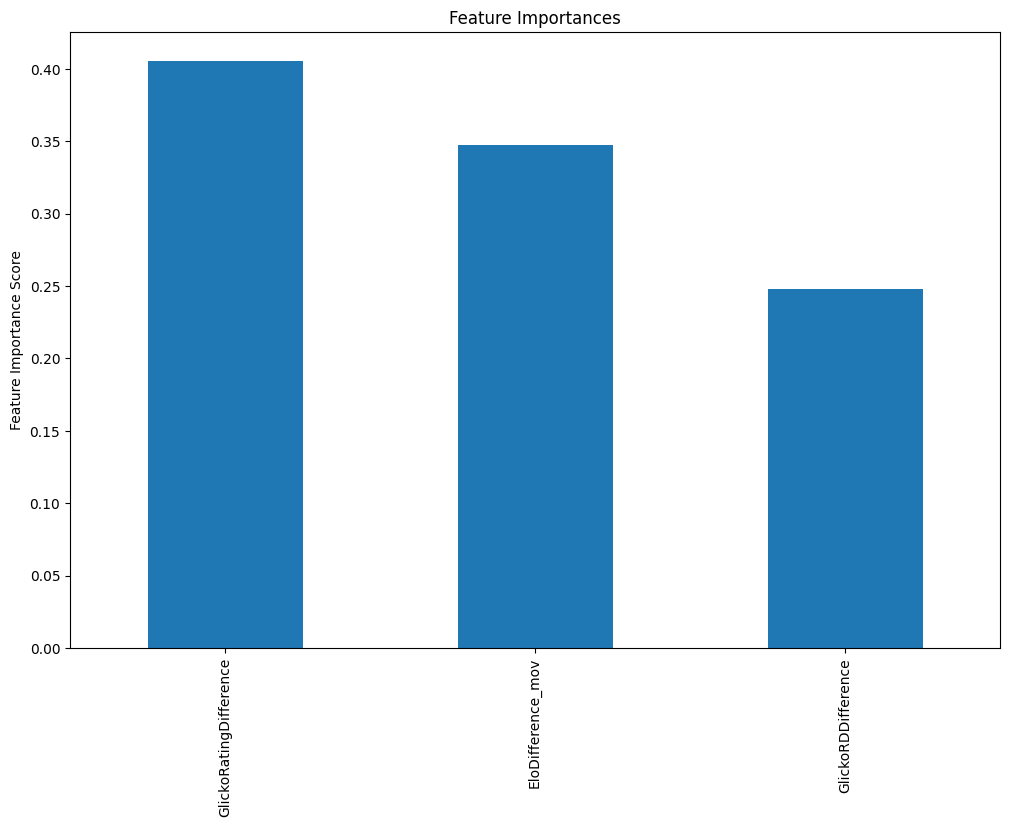

In [974]:
modelfitx(xgb0, X_train, y_train)

In [975]:
param_test1 = {
    'n_estimators': range(10, 200, 10)
}

gsearch1 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        objective='multi:softprob',
        num_class=3,
        random_state=10,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test1,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch1.fit(X_train, y_train)

print("Best parameters:", gsearch1.best_params_)
print("Best score:", gsearch1.best_score_)


Best parameters: {'n_estimators': 20}
Best score: 0.6646846375917139


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [976]:
best_n_estimators = gsearch1.best_params_['n_estimators']


In [977]:
param_test2 = {
    'max_depth': range(4, 15, 1),
    'min_child_weight': range(1, 10, 1)
}

gsearch2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=best_n_estimators,
        objective='multi:softprob',
        num_class=3,
        random_state=10,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test2,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch2.fit(X_train, y_train)

print("Best parameters:", gsearch2.best_params_)
print("Best score:", gsearch2.best_score_)


Best parameters: {'max_depth': 4, 'min_child_weight': 9}
Best score: 0.6693829506657727


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [978]:
best_max_depth = gsearch2.best_params_['max_depth']
best_min_child_weight = gsearch2.best_params_['min_child_weight']


In [979]:
param_test3 = {
    'gamma': [i/10.0 for i in range(0, 5)]
}

gsearch3 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        objective='multi:softprob',
        num_class=3,
        random_state=10,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test3,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch3.fit(X_train, y_train)

print("Best parameters:", gsearch3.best_params_)
print("Best score:", gsearch3.best_score_)


Best parameters: {'gamma': 0.1}
Best score: 0.6694385155166169


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [980]:
best_gamma = gsearch3.best_params_['gamma']


In [981]:
param_test4 = {
    'subsample': [i/10.0 for i in range(2,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        gamma=best_gamma,
        objective='multi:softprob',
        num_class=3,
        random_state=10,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test4,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch4.fit(X_train, y_train)

print("Best parameters:", gsearch4.best_params_)
print("Best score:", gsearch4.best_score_)


Best parameters: {'colsample_bytree': 0.7, 'subsample': 0.9}
Best score: 0.6711358262715614


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [982]:
best_subsample = gsearch4.best_params_['subsample']
best_colsample_bytree = gsearch4.best_params_['colsample_bytree']


In [983]:
param_test5 = {
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
}

gsearch5 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        gamma=best_gamma,
        subsample=best_subsample,
        colsample_bytree=best_colsample_bytree,
        objective='multi:softprob',
        num_class=3,
        random_state=10,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    param_grid=param_test5,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    cv=5
)

gsearch5.fit(X_train, y_train)

print("Best parameters:", gsearch5.best_params_)
print("Best score:", gsearch5.best_score_)


Best parameters: {'reg_alpha': 0.01}
Best score: 0.6713663543747429


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [984]:
best_reg_alpha = gsearch5.best_params_['reg_alpha']


In [985]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

final_model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    sample_weight=sample_weights,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha=best_reg_alpha,
    objective='multi:softprob',
    num_class=3,
    random_state=10,
    use_label_encoder=False,
    eval_metric='mlogloss',
    
)

final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    
    verbose=True
)


[0]	validation_0-mlogloss:1.07928	validation_1-mlogloss:1.08093
[1]	validation_0-mlogloss:1.06286	validation_1-mlogloss:1.06598
[2]	validation_0-mlogloss:1.04934	validation_1-mlogloss:1.05383
[3]	validation_0-mlogloss:1.03740	validation_1-mlogloss:1.04338
[4]	validation_0-mlogloss:1.02741	validation_1-mlogloss:1.03489
[5]	validation_0-mlogloss:1.01878	validation_1-mlogloss:1.02754
[6]	validation_0-mlogloss:1.01127	validation_1-mlogloss:1.02124
[7]	validation_0-mlogloss:1.00476	validation_1-mlogloss:1.01585
[8]	validation_0-mlogloss:0.99922	validation_1-mlogloss:1.01144
[9]	validation_0-mlogloss:0.99429	validation_1-mlogloss:1.00763
[10]	validation_0-mlogloss:0.99008	validation_1-mlogloss:1.00432
[11]	validation_0-mlogloss:0.98640	validation_1-mlogloss:1.00152
[12]	validation_0-mlogloss:0.98306	validation_1-mlogloss:0.99910
[13]	validation_0-mlogloss:0.98035	validation_1-mlogloss:0.99724
[14]	validation_0-mlogloss:0.97791	validation_1-mlogloss:0.99578
[15]	validation_0-mlogloss:0.97561	

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sample_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-mlogloss:0.97194	validation_1-mlogloss:0.99275
[18]	validation_0-mlogloss:0.97041	validation_1-mlogloss:0.99189
[19]	validation_0-mlogloss:0.96914	validation_1-mlogloss:0.99130


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=9, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=20,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sample_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model Report
Accuracy : 0.537
AUC Score (Train): 0.694431975978274
CV Score : Mean - 0.6684767 | Std - 0.01095691 | Min - 0.6466637 | Max - 0.6753675


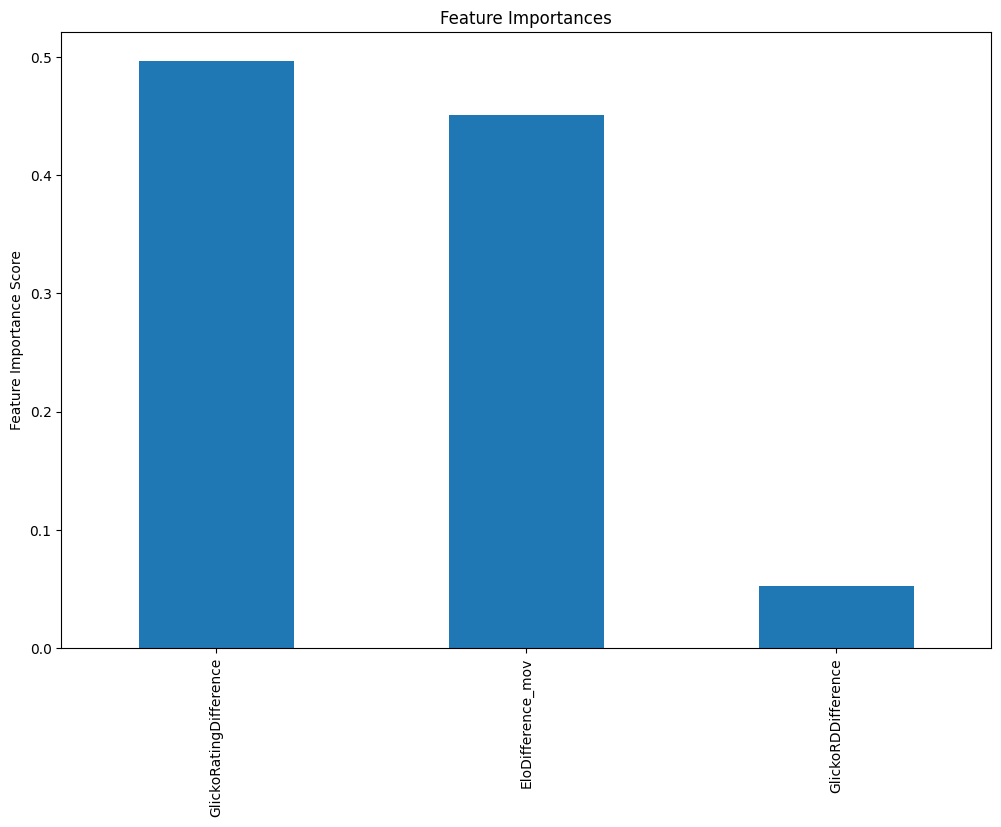

In [986]:
modelfitx(final_model,X_train,y_train)

In [987]:
# Predict on test data
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc}")


Confusion Matrix:
[[722 206   0]
 [310 394   0]
 [333 200   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.78      0.63       928
           1       0.49      0.56      0.52       704
           2       0.00      0.00      0.00       533

    accuracy                           0.52      2165
   macro avg       0.34      0.45      0.38      2165
weighted avg       0.39      0.52      0.44      2165

ROC AUC Score: 0.6602632908485618


C:\Users\ahmed\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahmed\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)


Model Report
Accuracy : 0.5554
AUC Score (Train): 0.735785
CV Score : Mean - 0.6567222 | Std - 0.01169756 | Min - 0.6414329 | Max - 0.6741145


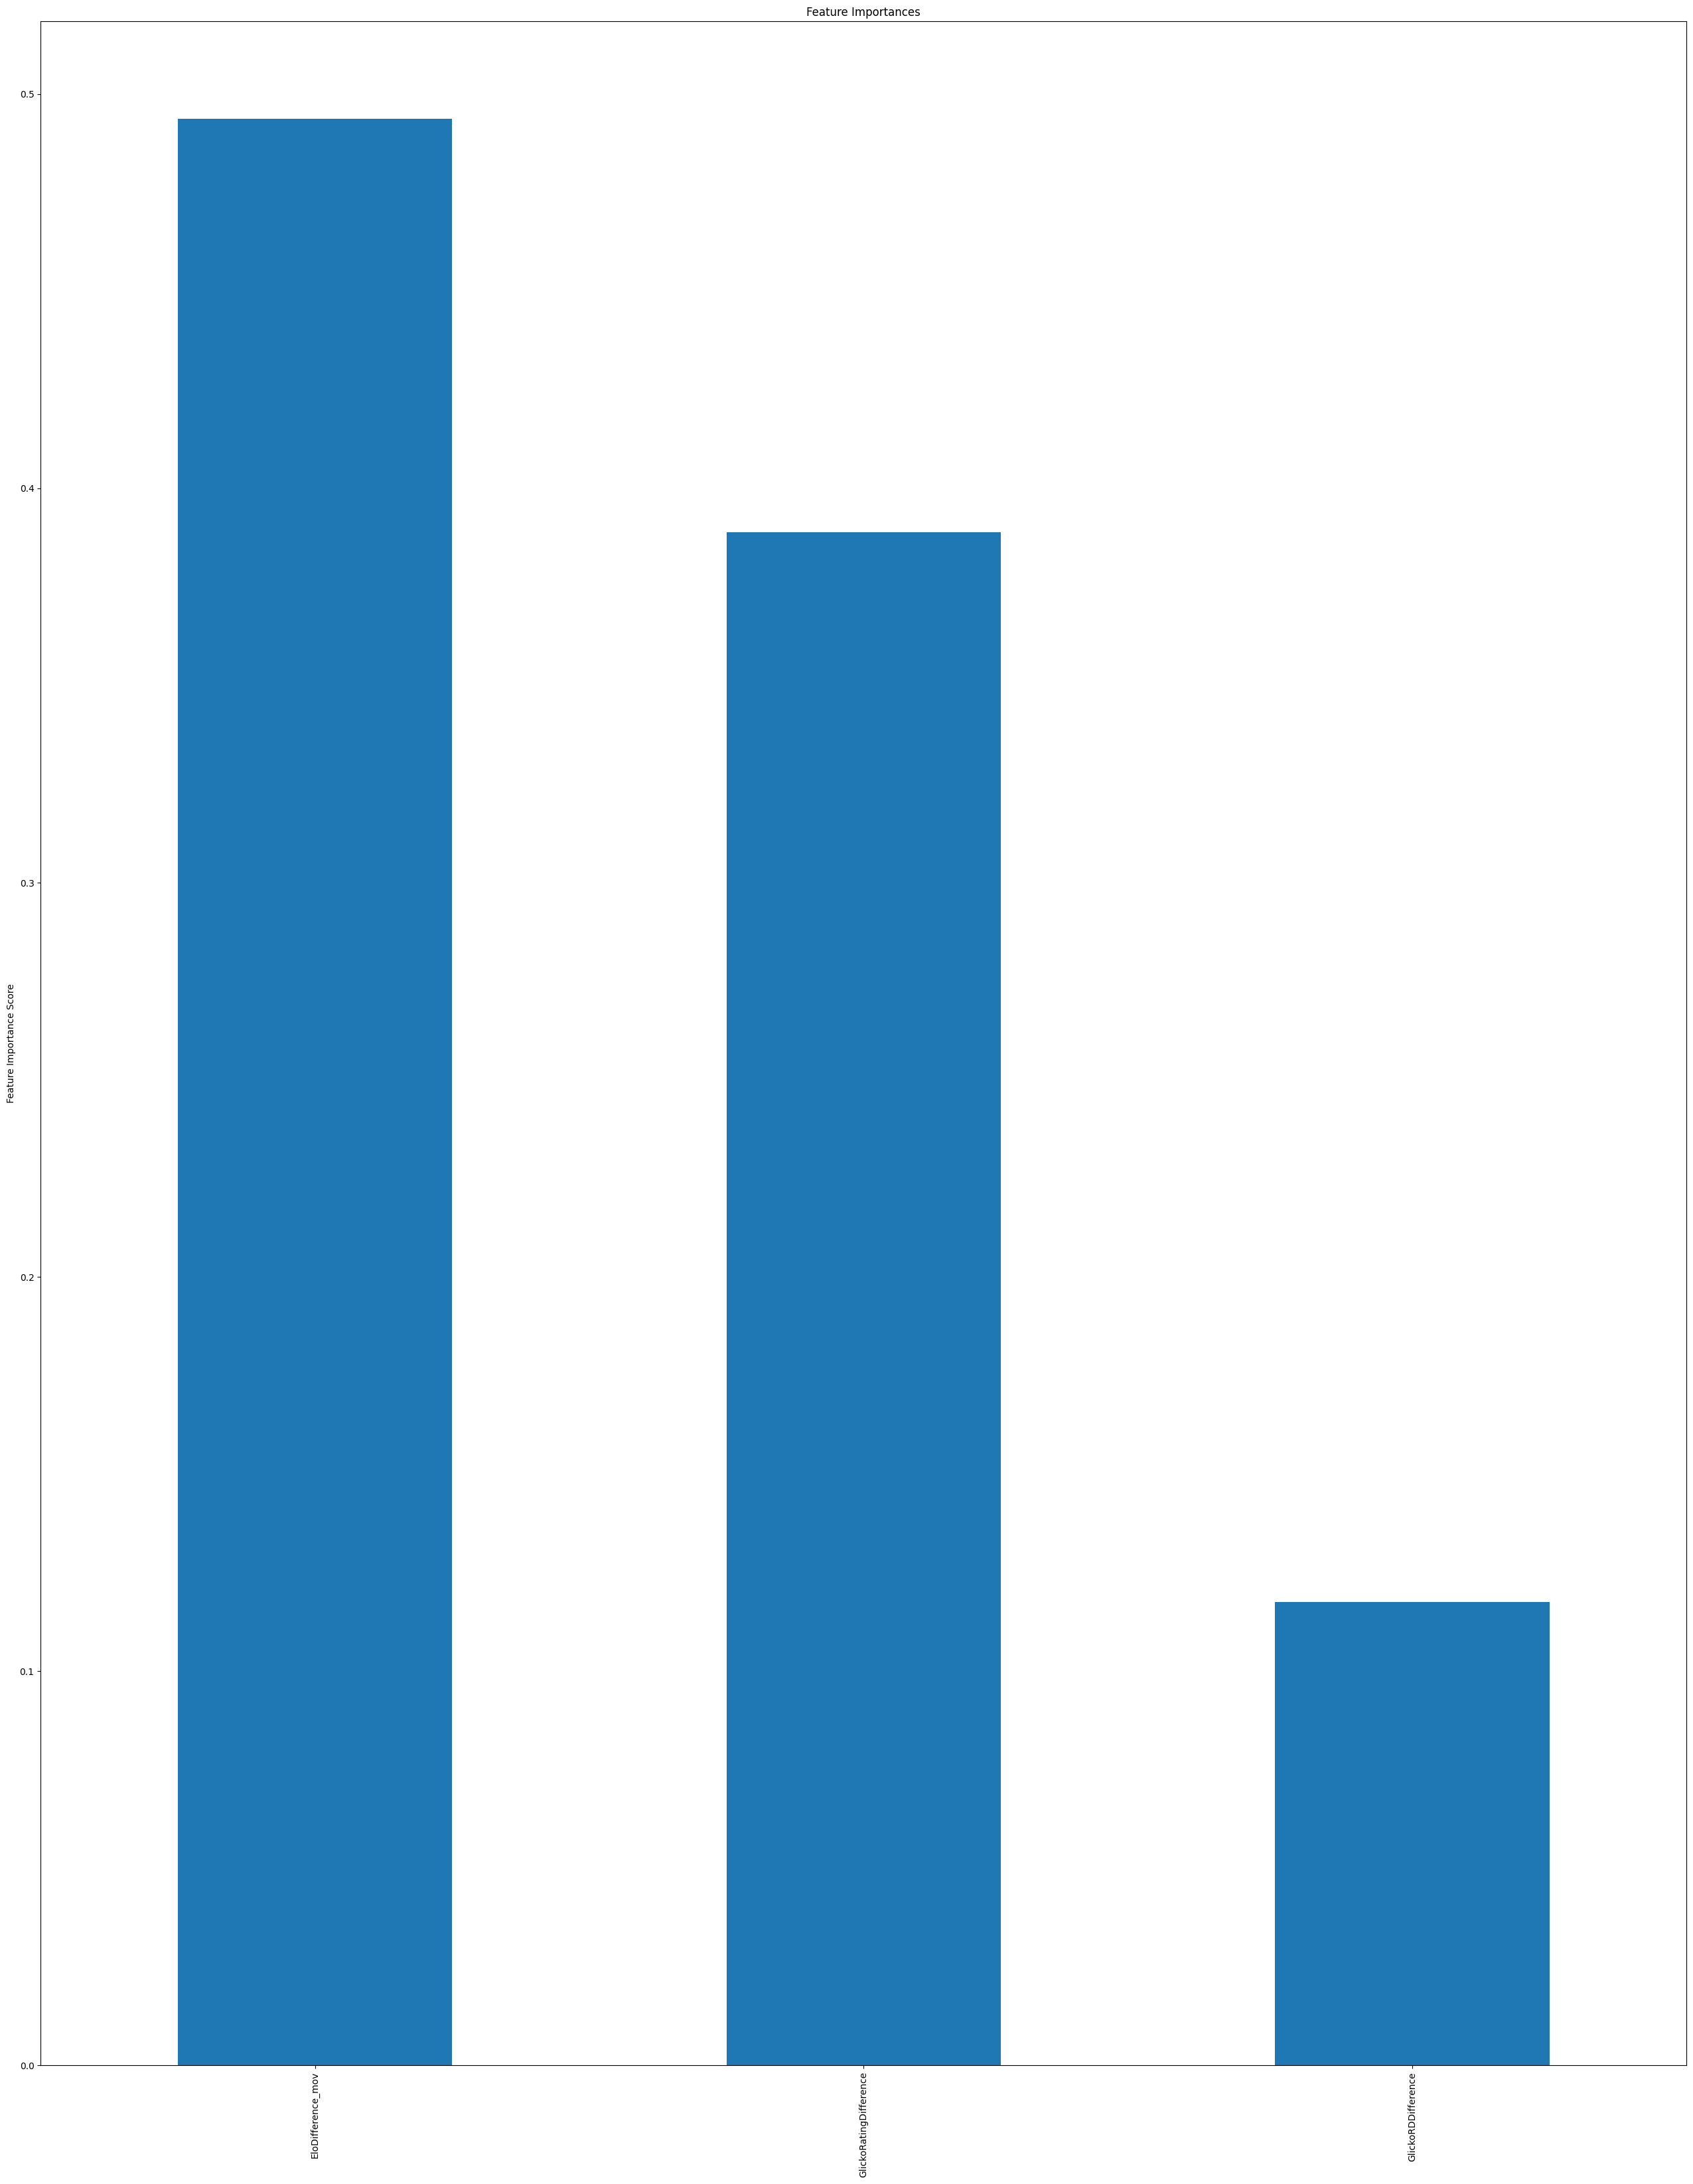

In [988]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0,X_train,y_train)

In [989]:
param_test1 = {'n_estimators':range(10,100,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=7,min_samples_leaf=3,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc_ovr',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=3,
                                                  min_samples_split=7,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(10, 100, 5)},
             scoring='roc_auc_ovr')

In [990]:
print(gsearch1.cv_results_)  # Access cross-validation results

{'mean_fit_time': array([0.49262156, 0.75837474, 1.10195885, 1.57229877, 1.6236846 ,
       1.80207057, 2.14859948, 2.60462923, 2.46513333, 2.76451898,
       3.05372686, 3.36009178, 3.66190906, 4.05805736, 4.02525778,
       4.4829536 , 4.31957121, 4.40359197]), 'std_fit_time': array([0.00791689, 0.01946566, 0.09787704, 0.04438884, 0.09495874,
       0.08599659, 0.05974376, 0.10965831, 0.03067897, 0.11086361,
       0.06603152, 0.08445462, 0.10638412, 0.06517152, 0.04037312,
       0.15648337, 0.03401116, 0.05559747]), 'mean_score_time': array([0.00852094, 0.00853319, 0.01099906, 0.01240172, 0.01030493,
       0.01299953, 0.01310549, 0.01361294, 0.01279635, 0.01490569,
       0.01459761, 0.01524372, 0.02000179, 0.01780958, 0.01836624,
       0.01860151, 0.01995649, 0.0181942 ]), 'std_score_time': array([0.00121622, 0.0007767 , 0.00209215, 0.00280018, 0.00086891,
       0.00089934, 0.00287048, 0.00160519, 0.00096854, 0.00174291,
       0.00079904, 0.0014363 , 0.00141546, 0.00360186, 0.

In [991]:
print(gsearch1.best_params_)  # Best parameters found

{'n_estimators': 15}


In [992]:
print(gsearch1.best_score_)   # Best score

0.6607811566699671


In [993]:
best_estimators = list(gsearch1.best_params_.values())[0]

In [994]:
param_test2 = {'max_depth':range(3,20,1), 'min_samples_split':range(4,10,1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=best_estimators, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc_ovr',n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)

KeyboardInterrupt: 

In [943]:
print(gsearch2.cv_results_)  # Access cross-validation results

{'mean_fit_time': array([0.28226147, 0.27791009, 0.2845037 , 0.27783909, 0.27642007,
       0.28368592, 0.36226664, 0.35606718, 0.33473349, 0.33854775,
       0.36019521, 0.35143399, 0.44491129, 0.45429287, 0.43907552,
       0.41587901, 0.43872871, 0.42188354, 0.50970969, 0.51421804,
       0.49373927, 0.48857641, 0.51885576, 0.50053821, 0.64231229,
       0.59417443, 0.56892653, 0.56113892, 0.56149106, 0.57346063,
       0.79976373, 0.83873758, 0.81474538, 0.75223227, 0.72647672,
       0.67981768, 0.83364048, 0.81706419, 0.80838161, 0.8697607 ,
       0.84122496, 0.7958612 , 0.95193338, 0.92828226, 0.95051279,
       0.86688776, 0.86377234, 0.84989686, 1.03030543, 1.07475176,
       1.03269749, 1.00932918, 1.03356385, 1.00885711, 1.20784245,
       1.18132987, 1.07948575, 1.16048408, 1.09957423, 1.02458887,
       1.27775669, 1.27908869, 1.25307479, 1.20182829, 1.15211787,
       1.19814506, 1.52216201, 1.42549162, 1.40616241, 1.32510495,
       1.25149078, 1.3386682 , 1.94566083, 1

In [944]:
print(gsearch2.best_params_)  # Best parameters found

{'max_depth': 3, 'min_samples_split': 7}


In [945]:
print(gsearch2.best_score_)   # Best scor2


0.67148512747698


In [946]:
gsearch2.best_params_

{'max_depth': 3, 'min_samples_split': 7}

In [947]:
best_depth = list(gsearch2.best_params_.values())[0]
best_samples = list(gsearch2.best_params_.values())[1]
print(best_estimators,best_depth,best_samples)

10 3 7


In [948]:
param_test3 = {'min_samples_leaf':range(4,15,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=best_estimators, max_features='sqrt', subsample=0.8, random_state=10,max_depth=best_depth,min_samples_split=best_samples), 
param_grid = param_test3, scoring='roc_auc_ovr',n_jobs=4, cv=5)


In [949]:
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  min_samples_split=7,
                                                  n_estimators=10,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'min_samples_leaf': range(4, 15)},
             scoring='roc_auc_ovr')

In [950]:
print(gsearch3.cv_results_)  # Access cross-validation results

{'mean_fit_time': array([0.29065862, 0.29006653, 0.33921947, 0.32037749, 0.31153793,
       0.2989697 , 0.28923941, 0.29062681, 0.27862635, 0.27108412,
       0.27208261]), 'std_fit_time': array([0.00933847, 0.02510645, 0.02054614, 0.02624396, 0.00309474,
       0.01008382, 0.00942047, 0.00337003, 0.00317131, 0.01086306,
       0.00591629]), 'mean_score_time': array([0.00590458, 0.00600147, 0.0074019 , 0.00700402, 0.00780616,
       0.00771232, 0.00639639, 0.00599647, 0.00660758, 0.00560451,
       0.00526414]), 'std_score_time': array([0.00019006, 0.00126889, 0.00135597, 0.00109875, 0.00074386,
       0.00086113, 0.00048695, 0.00154992, 0.00101736, 0.00079426,
       0.00102939]), 'param_min_samples_leaf': masked_array(data=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'min_samples_leaf': 4}, {'min_samples_leaf': 5}

In [951]:
print(gsearch3.best_params_)  # Best parameters found

{'min_samples_leaf': 4}


In [952]:
print(gsearch3.best_score_)   # Best scor2


0.6716904973022488


In [953]:
best_samples_leaf = list(gsearch3.best_params_.values())[0]


Model Report
Accuracy : 0.5318
AUC Score (Train): 0.687235
CV Score : Mean - 0.6652517 | Std - 0.01191534 | Min - 0.6471644 | Max - 0.6805328


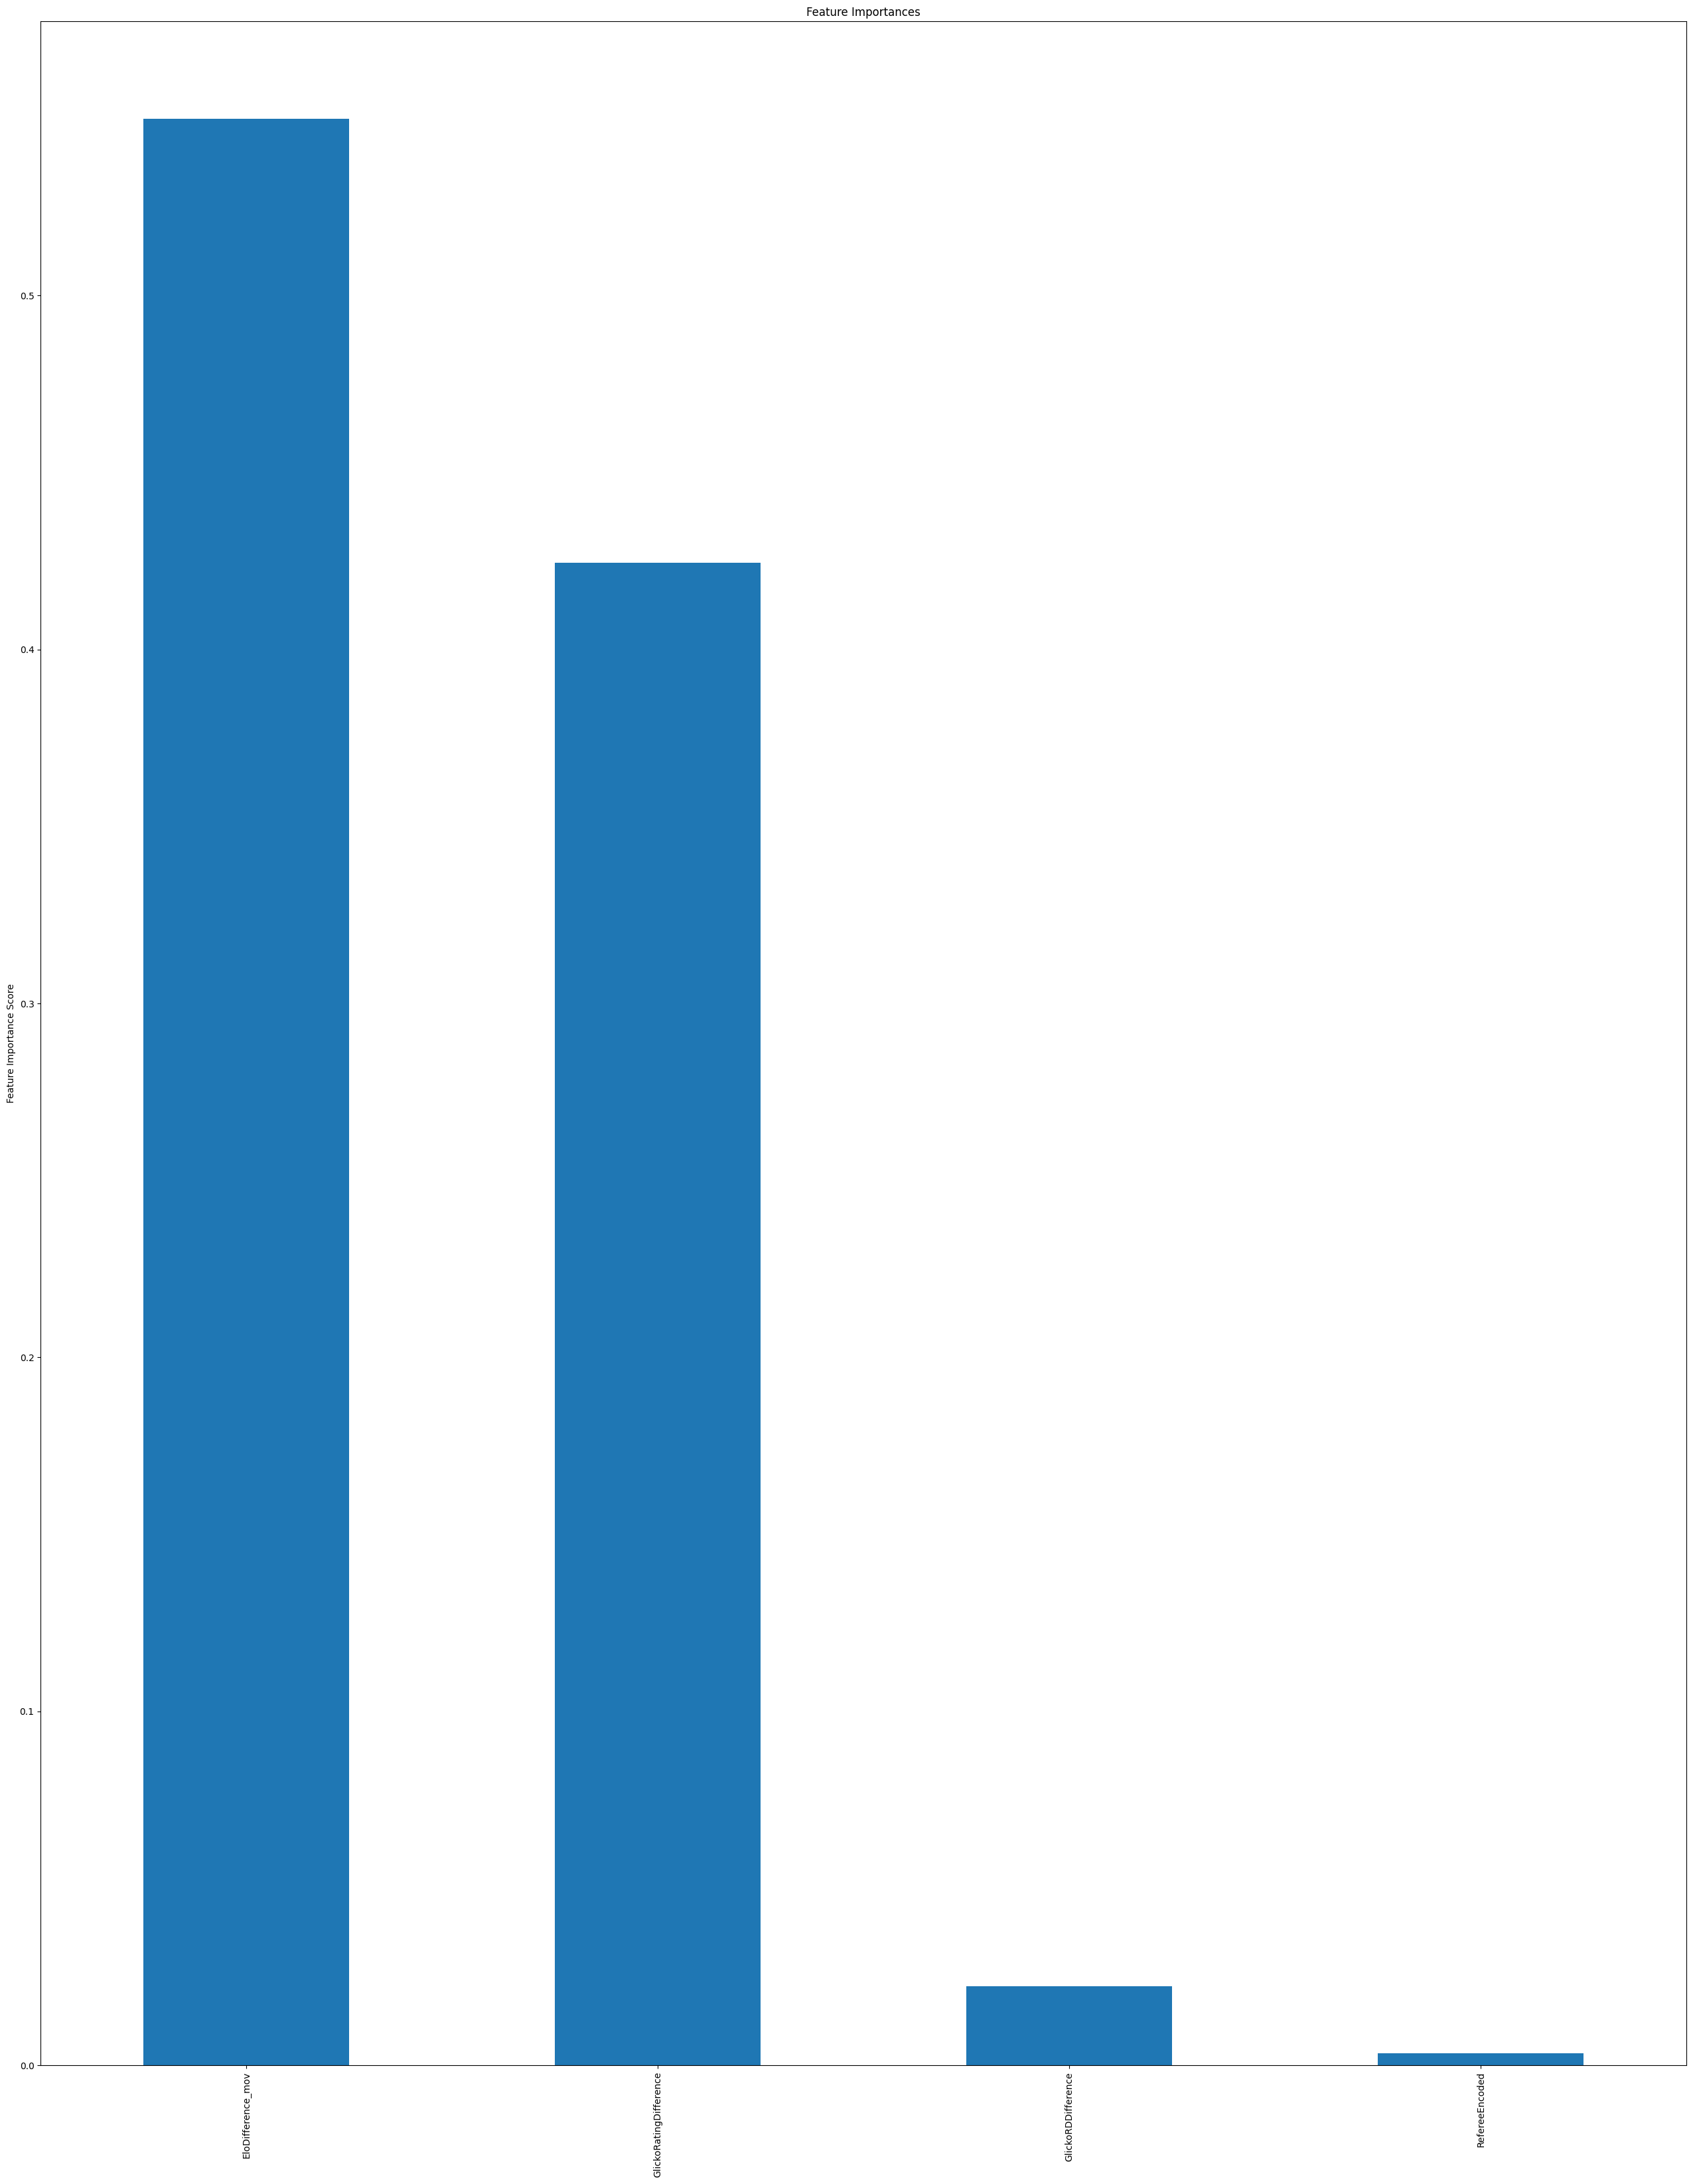

In [954]:
model_test = GradientBoostingClassifier(learning_rate=0.1, n_estimators=best_estimators, max_features='sqrt', subsample=0.8, random_state=10,max_depth=best_depth,min_samples_split=best_samples,min_samples_leaf=best_samples_leaf)
modelfit(model_test,X_train,y_train)

In [955]:
# df = df.drop(columns=['HomeTeam_home_games','HomeTeam_away_games','HomeTeam_goals_for','HomeTeam_goals_against','AwayTeam_home_games','AwayTeam_away_games','AwayTeam_goals_for','AwayTeam_goals_against'])
# df = df.drop(columns=['HomeTeamPosition','HomeTeamWinStreak', 'HomeTeamUnbeatenStreak','AwayTeamPosition','AwayTeamWinStreak', 'AwayTeamUnbeatenStreak'])

In [960]:
referee_mapping

{'A Madley': 0,
 'A Marriner': 1,
 'A Moss': 2,
 'A Taylor': 3,
 'C Kavanagh': 4,
 'C Pawson': 5,
 'D Bond': 6,
 'D Coote': 7,
 'D England': 8,
 'G Scott': 9,
 'J Brooks': 10,
 'J Gillett': 11,
 'J Gillett ': 12,
 'J Moss': 13,
 'J Smith': 14,
 'K Friend': 15,
 'L Mason': 16,
 'L Smith': 17,
 'M Atkinson': 18,
 'M Dean': 19,
 'M Donohue': 20,
 'M Oliver': 21,
 'M Salisbury': 22,
 'O Langford': 23,
 'P Bankes': 24,
 'P Tierney': 25,
 'R Jones': 26,
 'R Madley': 27,
 'R Welch': 28,
 'S Allison': 29,
 'S Attwell': 30,
 'S Barrott': 31,
 'S Hooper': 32,
 'S Scott': 33,
 'S Singh': 34,
 'T Bramall': 35,
 'T Harrington': 36,
 'T Robinson': 37,
 nan: 38}

In [1021]:
from sklearn.preprocessing import StandardScaler

# Function to get the most recent stats for a team
def get_most_recent_team_stats(df, team_numeric, prefix):
    # Filter for matches where the team is either home or away
    team_matches = df[(df['HomeTeam'] == team_numeric) | (df['AwayTeam'] == team_numeric)]
    
    # Check if the team has played any matches
    if team_matches.empty:
        return f"No matches found for team {team_numeric}"
    
    # Get the latest match for the team (assuming the dataframe is already sorted by date)
    latest_match = team_matches.iloc[-1]
    
    # Extract relevant stats based on the provided prefix (HomeTeam or AwayTeam)
    if prefix == 'HomeTeam':
        team_stats = latest_match[[col for col in df.columns if col.startswith('HomeTeam')]].to_dict()
    else:  # For AwayTeam
        team_stats = latest_match[[col for col in df.columns if col.startswith('AwayTeam')]].to_dict()

    return team_stats

most_recent_stats = get_most_recent_team_stats(df, 'Bayern Munich', 'HomeTeam')
(most_recent_stats)


{'HomeTeam': 'Bayern Munich',
 'HomeTeam_home_games': 1.0,
 'HomeTeam_away_games': 3.0,
 'HomeTeam_goals_for': 16.0,
 'HomeTeam_goals_against': 3.0,
 'HomeTeam_avg_home_goals': 2.0,
 'HomeTeam_avg_away_goals': 4.666666666666667,
 'HomeTeam_avg_home_corners': 2.0,
 'HomeTeam_avg_away_corners': 7.0,
 'HomeTeam_avg_home_fouls': 13.0,
 'HomeTeam_avg_away_fouls': 11.666666666666666,
 'HomeTeam_avg_home_yellow_cards': 1.0,
 'HomeTeam_avg_away_yellow_cards': 2.3333333333333335,
 'HomeTeam_avg_home_shots': 11.0,
 'HomeTeam_avg_away_shots': 20.666666666666668,
 'HomeTeam_avg_home_shots_target': 4.0,
 'HomeTeam_avg_away_shots_target': 9.333333333333334,
 'HomeTeamCumulativePoints': 12.0,
 'HomeTeamPosition': 1.0,
 'HomeTeamWinStreak': 4,
 'HomeTeamUnbeatenStreak': 4,
 'HomeTeamDaysSinceLastMatch': 7.0,
 'HomeTeamElo': 1864.1202354563382,
 'HomeTeamElo_d': 2106.0247042195647,
 'HomeTeamElo_mov': 2211.6229722882094,
 'HomeTeamGlickoRating': 2057.2124849137754,
 'HomeTeamGlickoRD': 68.6859011803487

In [475]:
odds = {
    'B365CH':1.8,  # Home win odds
    'B365CD': 3.66,  # Draw odds
    'B365CA': 5.15,
    'B365C<2.5':2.0,
    'B365C>2.5':1.8,
    'B365CAHH':2.02,
    'B365CAHA':1.87,
    # Away win odds
}

In [476]:
teams

{'AVS',
 'Ajaccio',
 'Alaves',
 'Almeria',
 'Amiens',
 'Angers',
 'Arouca',
 'Arsenal',
 'Aston Villa',
 'Atalanta',
 'Ath Bilbao',
 'Ath Madrid',
 'Augsburg',
 'Auxerre',
 'Aves',
 'Barcelona',
 'Bayern Munich',
 'Belenenses',
 'Benevento',
 'Benfica',
 'Betis',
 'Bielefeld',
 'Boavista',
 'Bochum',
 'Bologna',
 'Bordeaux',
 'Bournemouth',
 'Brentford',
 'Brescia',
 'Brest',
 'Brighton',
 'Burnley',
 'Cadiz',
 'Cagliari',
 'Casa Pia',
 'Celta',
 'Chaves',
 'Chelsea',
 'Clermont',
 'Como',
 'Cremonese',
 'Crotone',
 'Crystal Palace',
 'Darmstadt',
 'Dijon',
 'Dortmund',
 'Eibar',
 'Ein Frankfurt',
 'Elche',
 'Empoli',
 'Espanol',
 'Estoril',
 'Estrela',
 'Everton',
 'FC Koln',
 'Famalicao',
 'Farense',
 'Fiorentina',
 'Fortuna Dusseldorf',
 'Freiburg',
 'Frosinone',
 'Fulham',
 'Genoa',
 'Getafe',
 'Gil Vicente',
 'Girona',
 'Granada',
 'Greuther Furth',
 'Guimaraes',
 'Heidenheim',
 'Hertha',
 'Hoffenheim',
 'Holstein Kiel',
 'Huesca',
 'Inter',
 'Ipswich',
 'Juventus',
 'Las Palmas',

In [477]:
referee_mapping

{'A Madley': 0,
 'A Marriner': 1,
 'A Moss': 2,
 'A Taylor': 3,
 'C Kavanagh': 4,
 'C Pawson': 5,
 'D Bond': 6,
 'D Coote': 7,
 'D England': 8,
 'G Scott': 9,
 'J Brooks': 10,
 'J Gillett': 11,
 'J Gillett ': 12,
 'J Moss': 13,
 'J Smith': 14,
 'K Friend': 15,
 'L Mason': 16,
 'L Smith': 17,
 'M Atkinson': 18,
 'M Dean': 19,
 'M Donohue': 20,
 'M Oliver': 21,
 'M Salisbury': 22,
 'O Langford': 23,
 'P Bankes': 24,
 'P Tierney': 25,
 'R Jones': 26,
 'R Madley': 27,
 'R Welch': 28,
 'S Allison': 29,
 'S Attwell': 30,
 'S Barrott': 31,
 'S Hooper': 32,
 'S Scott': 33,
 'S Singh': 34,
 'T Bramall': 35,
 'T Harrington': 36,
 'T Robinson': 37,
 nan: 38}

In [478]:
df[columns_to_keep]

,CornerDifference,FoulDifference,ShotDifference,ShotOnTargetDifference,RefereeEncoded,DaysSinceLastMatchDifference,GlickoRatingDifference,GlickoRDDifference,EloDifference_mov
0,0.000000,0.000000,0.000000,0.000000,21,0.198484,1060.197334,0.000000,857.519465
1,0.000000,0.000000,0.000000,0.000000,38,0.198484,221.027950,0.000000,-137.451676
2,0.000000,0.000000,0.000000,0.000000,38,0.198484,8.484051,0.000000,-6.917318
3,0.000000,0.000000,0.000000,0.000000,38,0.198484,-105.589289,0.000000,-6.216043
4,0.000000,0.000000,0.000000,0.000000,38,0.198484,-218.977743,0.000000,-165.888260
...,...,...,...,...,...,...,...,...,...
10819,-0.666667,-0.333333,-1.666667,-0.333333,38,-2.000000,-144.752919,-5.018868,-250.681679
10820,-1.500000,-1.500000,-3.333333,1.500000,38,0.000000,-170.754685,1.063809,-225.650595
10821,1.166667,2.000000,-4.833333,0.166667,38,-1.000000,-336.480866,2.821093,-441.421696
10822,2.000000,0.000000,1.500000,0.000000,38,1.000000,-231.098367,2.513604,-321.563850


In [1173]:
from sklearn.preprocessing import StandardScaler

# Function to get the most recent stats for a team
def get_most_recent_team_stats(df, team_numeric, prefix):
    # Filter for matches where the team is either home or away
    team_matches = df[(df['HomeTeam'] == team_numeric) | (df['AwayTeam'] == team_numeric)]
    
    # Check if the team has played any matches
    if team_matches.empty:
        return f"No matches found for team {team_numeric}"
    
    # Get the latest match for the team (assuming the dataframe is already sorted by date)
    latest_match = team_matches.iloc[-1]
    
    # Extract relevant stats based on the provided prefix (HomeTeam or AwayTeam)
    if prefix == 'HomeTeam':
        team_stats = latest_match[[col for col in df.columns if col.startswith('HomeTeam')]].to_dict()
    else:  # For AwayTeam
        team_stats = latest_match[[col for col in df.columns if col.startswith('AwayTeam')]].to_dict()

    return team_stats

most_recent_stats = get_most_recent_team_stats(df, "Monza", 'AwayTeam')
(most_recent_stats)


{'AwayTeam': 'Monza',
 'AwayTeam_home_games': 3.0,
 'AwayTeam_away_games': 2.0,
 'AwayTeam_goals_for': 4.0,
 'AwayTeam_goals_against': 6.0,
 'AwayTeam_avg_home_goals': 0.6666666666666666,
 'AwayTeam_avg_away_goals': 1.0,
 'AwayTeam_avg_home_corners': 3.6666666666666665,
 'AwayTeam_avg_away_corners': 1.5,
 'AwayTeam_avg_home_fouls': 12.333333333333334,
 'AwayTeam_avg_away_fouls': 20.0,
 'AwayTeam_avg_home_yellow_cards': 2.0,
 'AwayTeam_avg_away_yellow_cards': 3.0,
 'AwayTeam_avg_home_shots': 6.666666666666667,
 'AwayTeam_avg_away_shots': 4.0,
 'AwayTeam_avg_home_shots_target': 2.3333333333333335,
 'AwayTeam_avg_away_shots_target': 2.0,
 'AwayTeamCumulativePoints': 3.0,
 'AwayTeamPosition': 19.0,
 'AwayTeamWinStreak': 0,
 'AwayTeamUnbeatenStreak': 0,
 'AwayTeamDaysSinceLastMatch': 7.0,
 'AwayTeamElo': 1595.778138845246,
 'AwayTeamElo_d': 1653.0835245725787,
 'AwayTeamElo_mov': 1656.7001230829612,
 'AwayTeamGlickoRating': 1657.3933280317822,
 'AwayTeamGlickoRD': 68.8445464023894,
 'AwayTe

In [1168]:
def generate_prediction_with_differences(df, home_team_numeric, away_team_numeric, model,):
    # Step 1: Get the most recent stats for both teams
    home_team_stats = get_most_recent_team_stats(df, home_team_numeric, 'AwayTeam')
    away_team_stats = get_most_recent_team_stats(df, away_team_numeric, 'HomeTeam')

    home_elo = home_team_stats['AwayTeamElo_mov']
    away_elo = away_team_stats['HomeTeamElo_mov']
    home_glicko = home_team_stats['AwayTeamGlickoRating']
    away_glicko = away_team_stats['HomeTeamGlickoRating']
    home_rd = home_team_stats['AwayTeamGlickoRD']
    away_rd = away_team_stats['HomeTeamGlickoRD']
    f_home = df['TotalHomeWins'].tail(1)
    f_away=df['TotalAwayWins'].tail(1)
    
    H = math.log10(f_home / f_away)
    print(home_elo)
    print(away_elo)
   
   
    feature_dict = {
        'GlickoRatingDifference': home_glicko - away_glicko,
        'GlickoRDDifference':home_rd - away_rd,
        'EloDifference_mov': home_elo + H  - away_elo
        # Referee and Days Since Last Match
    }



    features_df = pd.DataFrame([feature_dict])
    prediction = model.predict_proba(features_df)

    return prediction


# Assuming `model_test` is your trained model
prediction = generate_prediction_with_differences(df, "Bologna" , "Parma", final_model)
print(prediction)



1898.5723842595592
1370.3581300546534
[[0.60247236 0.14539587 0.2521318 ]]


C:\Users\ahmed\AppData\Local\Temp\ipykernel_10308\3489152711.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  H = math.log10(f_home / f_away)


In [479]:
# import pandas as pd

# def generate_prediction_with_differences(df, home_team_numeric, away_team_numeric,model):
#     # Step 1: Get the most recent stats for both teams
#     home_team_stats = get_most_recent_team_stats(df, home_team_numeric, 'HomeTeam')
#     away_team_stats = get_most_recent_team_stats(df, away_team_numeric, 'AwayTeam')

#     home_elo = home_team_stats['HomeTeamElo']
#     away_elo = away_team_stats['AwayTeamElo']
    
#     home_sos = home_team_stats['HomeTeamSoS']
#     away_sos = away_team_stats['AwayTeamSoS']
    
#     home_form = home_team_stats['HomeTeamForm']
#     away_form = away_team_stats['AwayTeamForm']
    
#     ref = ref_map.get(referee)

#     # Step 3: Combine the necessary features for prediction including all required differences
#     feature_dict = {
#         # 'B365CH': odds['B365CH'],
#         # 'B365CD': odds['B365CD'],
#         # 'B365CA': odds['B365CA'],
#         # 'B365C>2.5': odds['B365C>2.5'],
#         # 'B365C<2.5': odds['B365C<2.5'],
#         # 'B365CAHA': odds['B365CAHA'],
#         # 'B365CAHH': odds['B365CAHH'],

#         # Home Team stats
#         'HomeTeam_avg_home_goals': home_team_stats['HomeTeam_avg_home_goals'],
#         'HomeTeam_avg_away_goals': home_team_stats['HomeTeam_avg_away_goals'],
#         'HomeTeam_avg_home_corners': home_team_stats['HomeTeam_avg_home_corners'],
#         'HomeTeam_avg_away_corners': home_team_stats['HomeTeam_avg_away_corners'],
#         'HomeTeam_avg_home_fouls': home_team_stats['HomeTeam_avg_home_fouls'],
#         'HomeTeam_avg_away_fouls': home_team_stats['HomeTeam_avg_away_fouls'],
#         'HomeTeam_avg_home_yellow_cards': home_team_stats['HomeTeam_avg_home_yellow_cards'],
#         'HomeTeam_avg_away_yellow_cards': home_team_stats['HomeTeam_avg_away_yellow_cards'],
#         'HomeTeam_avg_home_shots': home_team_stats['HomeTeam_avg_home_shots'],
#         'HomeTeam_avg_away_shots': home_team_stats['HomeTeam_avg_away_shots'],
#         'HomeTeam_avg_home_shots_target': home_team_stats['HomeTeam_avg_home_shots_target'],
#         'HomeTeam_avg_away_shots_target': home_team_stats['HomeTeam_avg_away_shots_target'],

#         # Away Team stats
#         'AwayTeam_avg_home_goals': away_team_stats['AwayTeam_avg_home_goals'],
#         'AwayTeam_avg_away_goals': away_team_stats['AwayTeam_avg_away_goals'],
#         'AwayTeam_avg_home_corners': away_team_stats['AwayTeam_avg_home_corners'],
#         'AwayTeam_avg_away_corners': away_team_stats['AwayTeam_avg_away_corners'],
#         'AwayTeam_avg_home_fouls': away_team_stats['AwayTeam_avg_home_fouls'],
#         'AwayTeam_avg_away_fouls': away_team_stats['AwayTeam_avg_away_fouls'],
#         'AwayTeam_avg_home_yellow_cards': away_team_stats['AwayTeam_avg_home_yellow_cards'],
#         'AwayTeam_avg_away_yellow_cards': away_team_stats['AwayTeam_avg_away_yellow_cards'],
#         'AwayTeam_avg_home_shots': away_team_stats['AwayTeam_avg_home_shots'],
#         'AwayTeam_avg_away_shots': away_team_stats['AwayTeam_avg_away_shots'],
#         'AwayTeam_avg_home_shots_target': away_team_stats['AwayTeam_avg_home_shots_target'],
#         'AwayTeam_avg_away_shots_target': away_team_stats['AwayTeam_avg_away_shots_target'],

#         # Differences and calculated values
#         'EloDifference': home_elo - away_elo,
#         'SoSDifference': home_sos - away_sos,
#         'FormDifference': home_form - away_form,
        
#         'HomeTeamDaysSinceLastMatch': home_team_stats['HomeTeamDaysSinceLastMatch'],
#         'AwayTeamDaysSinceLastMatch': away_team_stats['AwayTeamDaysSinceLastMatch'],
#         'GoalDifference': home_team_stats['HomeTeam_avg_home_goals'] - away_team_stats['AwayTeam_avg_away_goals'],
#         'CornerDifference': home_team_stats['HomeTeam_avg_home_corners'] - away_team_stats['AwayTeam_avg_away_corners'],
#         'FoulDifference': home_team_stats['HomeTeam_avg_home_fouls'] - away_team_stats['AwayTeam_avg_away_fouls'],
#         'YellowCardDifference': home_team_stats['HomeTeam_avg_home_yellow_cards'] - away_team_stats['AwayTeam_avg_away_yellow_cards'],
#         'ShotDifference': home_team_stats['HomeTeam_avg_home_shots'] - away_team_stats['AwayTeam_avg_away_shots'],
#         'ShotOnTargetDifference': home_team_stats['HomeTeam_avg_home_shots_target'] - away_team_stats['AwayTeam_avg_away_shots_target'],

#         # Referee and Days Since Last Match

#         'RefereeEncoded': ref,
#         'DaysSinceLastMatchDifference': home_team_stats['HomeTeamDaysSinceLastMatch'] - away_team_stats['AwayTeamDaysSinceLastMatch']
#     }


#     # Convert the feature dictionary into a DataFrame for the model
#     features_df = pd.DataFrame([feature_dict])

#     # Step 4: Make the prediction
#     prediction = model.predict_proba(features_df)

#     return prediction



# # Assuming `model_test` is your trained model
# prediction = generate_prediction_with_differences(df,17 , 11, odds, model_test)
# print(prediction)


KeyError: 'HomeTeamNumeric'

In [480]:
#prediction = generate_prediction_with_differences(df, 8, 14, odds, model_test, elo_ratings, latest_sos, team_form,referee_mapping,'T Robinson')
# prediction = generate_prediction_with_differences(df, 21, 9, odds, model_test, elo_ratings, latest_sos, team_form,referee_mapping,'S Barrott')
# prediction = generate_prediction_with_differences(df, 16, 27, odds, model_test, elo_ratings, latest_sos, team_form,referee_mapping,'S Barrott')
# prediction = generate_prediction_with_differences(df, 12, 20, odds, model_test, elo_ratings, latest_sos, team_form,referee_mapping,'S Barrott')
# prediction = generate_prediction_with_differences(df, 12, 20, odds, model_test, elo_ratings, latest_sos, team_form,referee_mapping,'S Barrott')

In [524]:
result_mapping = {'H': 0, 'A': 1, 'D': 2}
result_mapping

{'H': 0, 'A': 1, 'D': 2}

In [691]:
X_valid = X_test
y_valid = y_test

In [692]:
importances = final_model.feature_importances_
features = features.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

In [693]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.to_csv('imp.csv',index=False)

In [694]:
from sklearn.inspection import permutation_importance

result = permutation_importance(final_model, X_valid, y_valid, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'Feature': X_valid.columns, 'Importance': result.importances_mean})

In [695]:
perm_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
perm_importance_df.to_csv('perm.txt',index=False)

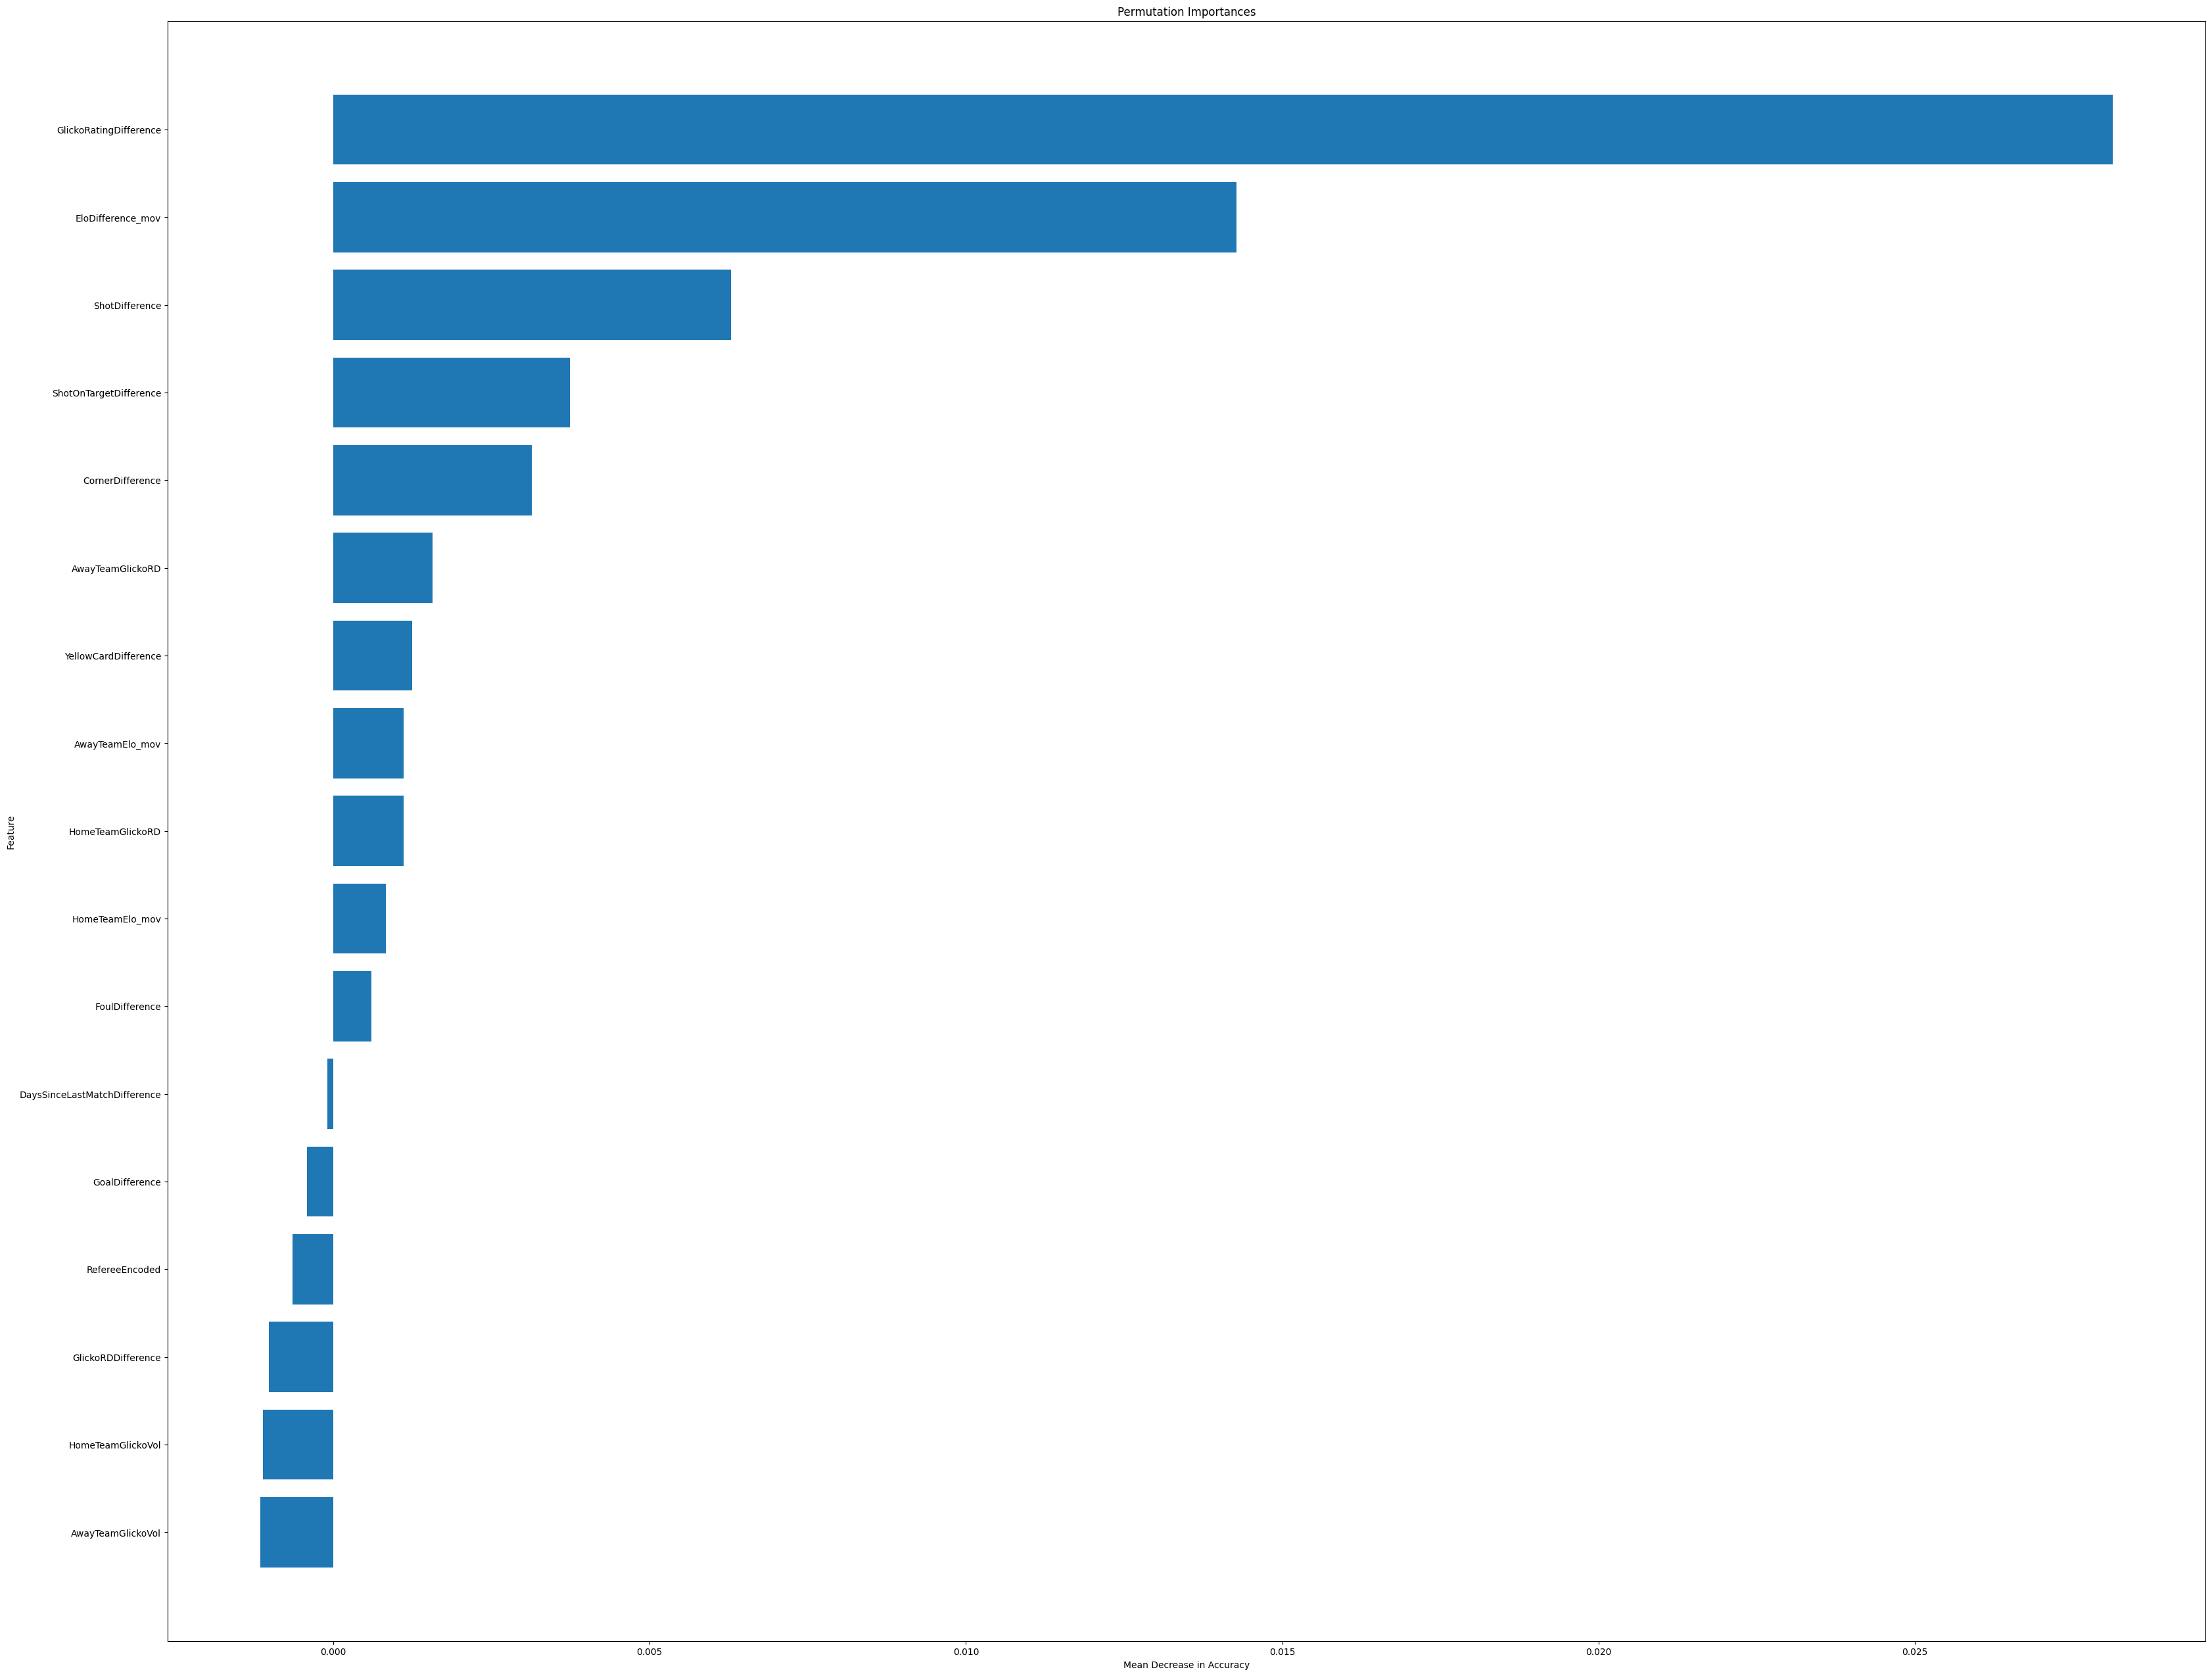

In [696]:
plt.figure(figsize=(40, 32))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Feature')
plt.title('Permutation Importances')
plt.gca().invert_yaxis()
plt.show()


In [697]:
importances = model_test.feature_importances_
#features = features.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

In [698]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.to_csv('imp.csv',index=False)

In [699]:
result = permutation_importance(model_test, X_valid, y_valid, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'Feature': X_valid.columns, 'Importance': result.importances_mean})

In [700]:
perm_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
perm_importance_df.to_csv('perm.txt',index=False)

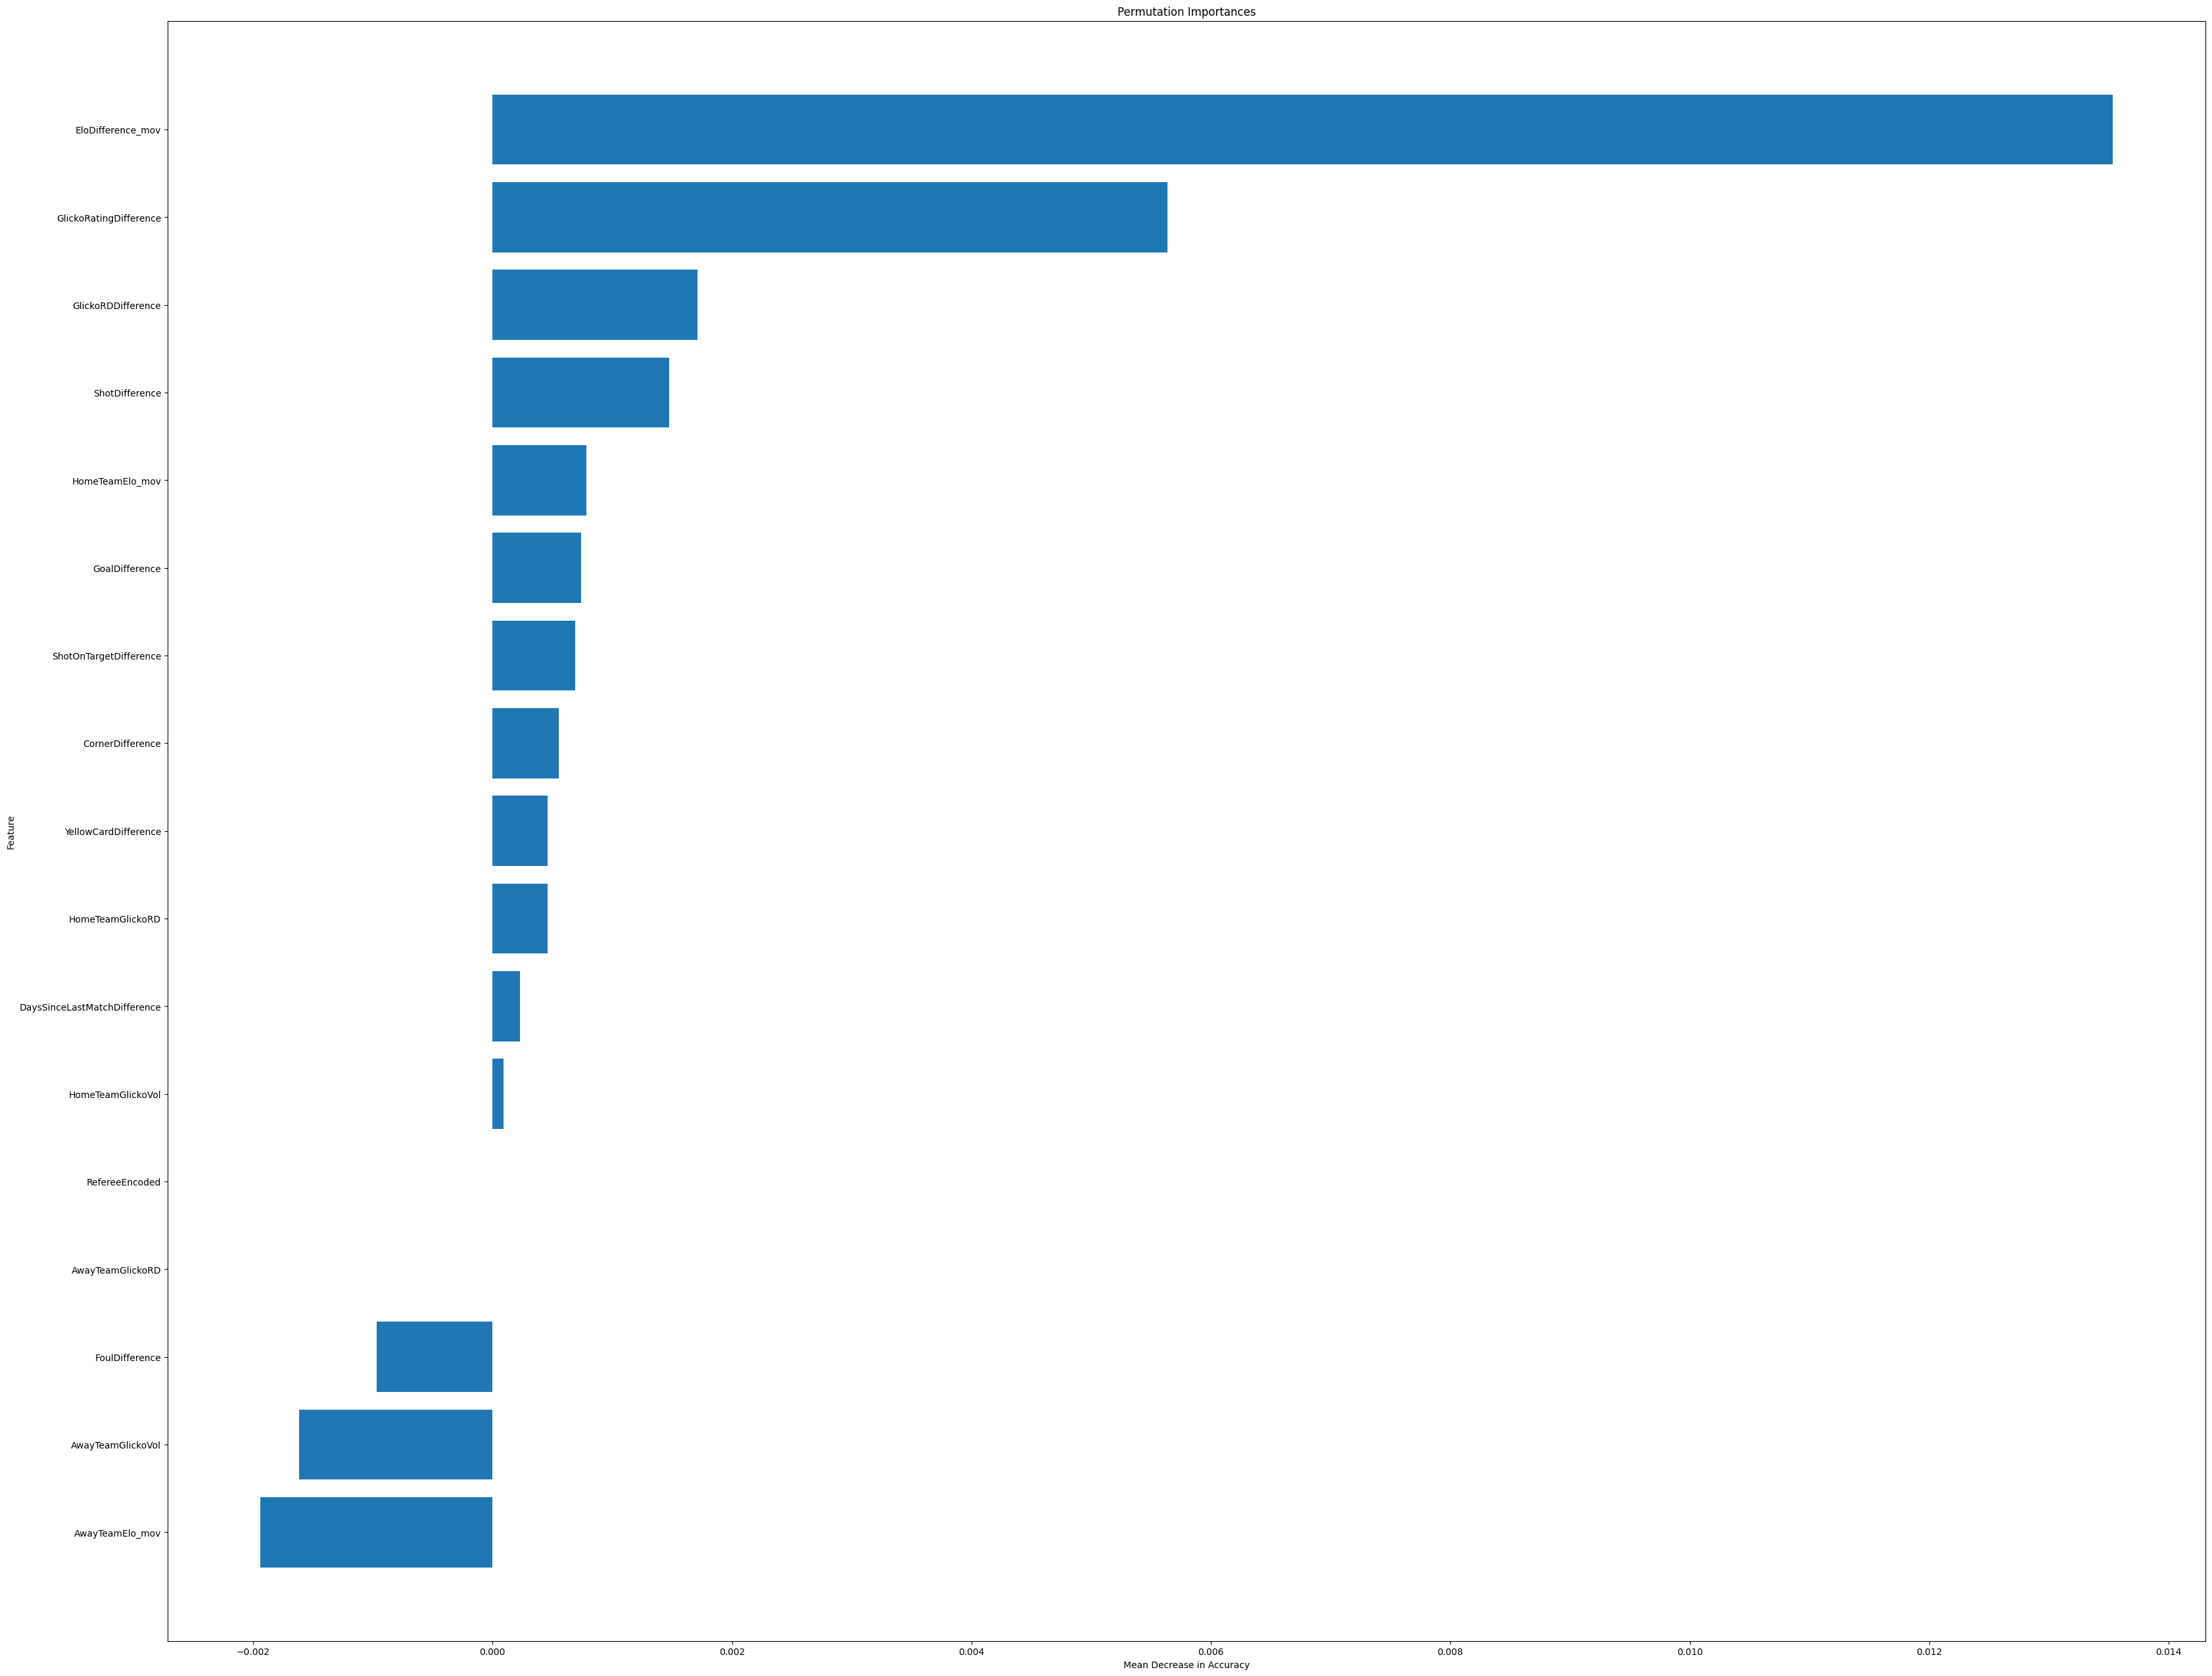

In [701]:
plt.figure(figsize=(40, 32))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'])
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Feature')
plt.title('Permutation Importances')
plt.gca().invert_yaxis()
plt.show()


In [702]:
# Make predictions on the test set
y_pred = final_model.predict(X_test)

# If you're using a classifier and want predicted probabilities (e.g., for ROC-AUC):
y_pred_proba = final_model.predict_proba(X_test)[:, 1]  # Use probability of the positive class


In [703]:
y_pred_proba

array([0.36565548, 0.5116436 , 0.20473878, ..., 0.16184656, 0.20755945,
       0.3362588 ], dtype=float32)

In [704]:
# # Reverse the mapping dictionary: mapping numeric values back to team names
# # Step 1: Reverse-map HomeTeamNumeric and AwayTeamNumeric back to team names
# reverse_teams = {v: k for k, v in teams.items()}

# # Step 2: Extract team names from test set (X_test)
# X_test['HomeTeamNumeric'] = X_test['HomeTeamNumeric'].map(reverse_teams)
# X_test['AwayTeamNumeric'] = X_test['AwayTeamNumeric'].map(reverse_teams)


# # Step 4: Combine predictions, real values, and team names into a single DataFrame
# results_df = pd.DataFrame({
#     'HomeTeam': X_test['HomeTeamNumeric'],     # Reversed Home Team names
#     'AwayTeam': X_test['AwayTeamNumeric'],     # Reversed Away Team names
#     'RealValue': y_test,                # Actual result (test set)
#     'Prediction': y_pred,
#     'Probability':y_pred_proba# Predicted result
# })

# # Step 5: Map back the actual FTR results if necessary
# reverse_mapping = {1: 'H', 2: 'A', 3: 'D'}
# results_df['RealValue'] = results_df['RealValue'].map(reverse_mapping)
# results_df['Prediction'] = results_df['Prediction'].map(reverse_mapping)

# # Step 6: Display the final DataFrame with predictions, real values, and team names

In [705]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)



print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:\n", cm)


Accuracy: 0.5210161662817552
Precision: 0.4545956738430708
Recall: 0.5210161662817552
F1 Score: 0.45037493212412105
Confusion Matrix:
 [[732 191   5]
 [301 390  13]
 [326 201   6]]


In [706]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.5509874119413327
Test Accuracy: 0.5210161662817552


In [707]:
y_train_pred = model_test.predict(X_train)
y_test_pred = model_test.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.540016168148747
Test Accuracy: 0.5168591224018476


In [708]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=7)
scores = cross_val_score(final_model, X_train, y_train, cv=tscv, scoring='accuracy')

print(f"Cross-validation scores: {scores}")
print(f"Mean CV score: {scores.mean()}")


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sample_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "sample_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Param

Cross-validation scores: [0.54621072 0.52495379 0.51109057 0.52865065 0.53789279 0.54436229
 0.51756007]
Mean CV score: 0.530102983892263


In [709]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=7)
scores = cross_val_score(model_test, X_train, y_train, cv=tscv, scoring='accuracy')

print(f"Cross-validation scores: {scores}")
print(f"Mean CV score: {scores.mean()}")


Cross-validation scores: [0.53974122 0.51478743 0.52033272 0.53327172 0.52957486 0.54436229
 0.512939  ]
Mean CV score: 0.5278584631634539


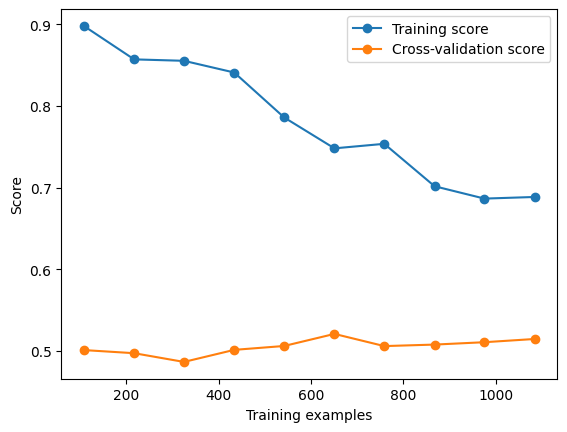

In [710]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    final_model, X_train, y_train, cv=tscv, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

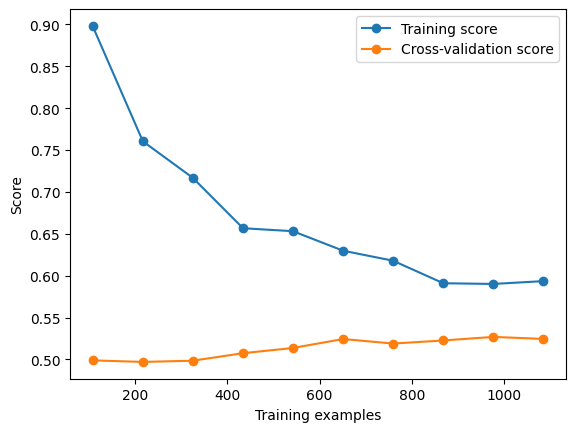

In [711]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model_test, X_train, y_train, cv=tscv, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [106]:
X_valid = X_test
y_valid = y_test


In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = features.corr().abs()

AttributeError: 'Index' object has no attribute 'corr'

In [108]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


NameError: name 'corr_matrix' is not defined

In [109]:
# Find features with correlation greater than a threshold
threshold = 0.9  # You can adjust this threshold
high_corr_var = np.where(corr_matrix > threshold)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

print("Highly correlated features (correlation > {}):".format(threshold))
for var_pair in high_corr_var:
    print(var_pair)


NameError: name 'corr_matrix' is not defined

In [82]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid)

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


InvalidModelError: GradientBoostingClassifier is only supported for binary classification right now!

In [ ]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]


In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(df)
low_variance_features = df.columns[~selector.get_support()]


In [ ]:
feature_names = X_train.columns

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. Feature: {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")

# Step 4: Plot the feature importances for visualization
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [1205]:
best_importances = best_model.feature_importances_

In [ ]:
feature_names = X_train.columns

# Sort the features by importance
indices = np.argsort(best_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. Feature: {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")

# Step 4: Plot the feature importances for visualization
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [1213]:
y_pred = model.predict(X_test)
y_pred = y_pred.round()

In [1214]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:\n", cm)


Accuracy: 0.47368421052631576
Precision: 0.3902897111523682
Recall: 0.47368421052631576
F1 Score: 0.4020406148987095
Confusion Matrix:
 [[14 17  0]
 [ 4 22  0]
 [ 5 14  0]]


C:\Users\ahmed\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Step 1: Make predictions on the test set
y_pred = best_model.predict(X_test)

# Step 2: Compare predictions vs actual results
comparison = pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted': y_pred.ravel()})


for i in comparison['Actual']:
    print("Actual: " , comparison['Actual'][i], "Predicted: " ,comparison['Predicted'][i].round())


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [300]:
xg_model = XGBRegressor()
light_model = LGBMRegressor()

NameError: name 'XGBRegressor' is not defined

In [301]:
targets = df['FTHG']
features = df.drop(columns=['FTHG', 'FTAG', 'HTHG', 'HTAG', 'Div','HomeResultPoints','AwayResultPoints','home_numerical','Time','HomeTeam', 'AwayTeam','Referee','IWH','IWD','IWA','IWCH','IWCD','IWCA'])
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)